<center><h1 style="font-size:2.5vw"> AML Project 2 </h1></center>

---
<div style="display:flex; flex-direction:row; width:35%; justify-content : space-between">
    <div style = "display : flex, flex-direction : column">
        <div><b><font color = "#3285d3">Authors</font></b></div>
        <div><b><font color = "#3285d3">Date</font></b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div>Albert Roathel, Marcel Affi</div>
        <div>April 2021</div>
    </div>
</div>

Feature selection is the process of selecting a subset of relevant features used to train a machine learning model, in this project we have been challenged to use these feature selection methods on two datasets :

<table style="width:100%">
  <tr>
    <th style="text-align:left">Dataset</th>
    <th style="text-align:left">Features</th>
    <th style="text-align:left">Train observations</th>
    <th style="text-align:left">Val observations</th>
  </tr>
  <tr>
    <td style="text-align:left">Artificial</td>
    <td style="text-align:left">500</td>
    <td style="text-align:left">2000</td>
    <td style="text-align:left">600</td>
  </tr>
  <tr>
    <td style="text-align:left">Digits</td>
    <td style="text-align:left">5000</td>
    <td style="text-align:left">6000</td>
    <td style="text-align:left">1000</td>
  </tr>
</table>

# Project outline

1. [Loading Data](#Loading_data)
2. [ElasticNet](#ElasticNet)
3. [Trees](#Trees)
4. [Recursive feature elimination](#RFE)
5. [Boruta](#Boruta)
5. [XGBoost](#XGBoost)

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.figsize'] = (10,5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['grid.color'] = 'w'
plt.style.use(['ggplot'])

import plotly.express as px
import plotly.graph_objects as go

<a id='Loading_data'></a>
# Load and transform the data

In [2]:
def read_from_url(dataset : str) -> (pd.DataFrame):
    train_data   = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_train.data', sep = ' ', header=None).iloc[:,:-1].values
    valid_data   = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_valid.data', sep = ' ', header=None).iloc[:,:-1].values
    train_labels = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_train.labels', header=None).values.ravel()

    return train_data, train_labels, valid_data

In [3]:
X_art, y_art, val_art = read_from_url('artificial')
X_dig, y_dig, val_dig = read_from_url('digits')

In [4]:
# Utility function to save the results
def save_to_file(dataset : str, predictions : np.array, feature_indices : list()):
    with open (f'ALBROE_{dataset}_features.txt', 'w+') as buffer:
        buffer.write("\"ALBROE\"\n")
        for feature_index in feature_indices:
            buffer.write(str(feature_index) + '\n')
    
    with open (f'ALBROE_{dataset}_predictions.txt', 'w+') as buffer:
        buffer.write("\"ALBROE\"\n")
        for prediction in predictions:
            buffer.write(str(prediction) + '\n')

In [5]:
print(f'Artifitial dataset: {X_art.shape[0]} observations, {X_art.shape[1]} features')
print(f'Digits dataset: {X_dig.shape[0]} observations, {X_dig.shape[1]} features')

Artifitial dataset: 2000 observations, 500 features
Digits dataset: 6000 observations, 5000 features


In [6]:
X_art = (X_art - X_art.mean(0)) / X_art.std()
val_art = (val_art - val_art.mean(0)) / val_art.std()

In [7]:
std = X_dig.std(0)
X_dig = X_dig[:, std != 0]
X_dig = (X_dig - X_dig.mean(0)) / std[std != 0]


In [8]:
X_art_train, X_art_test, y_art_train, y_art_test = sklearn.model_selection.train_test_split(
    X_art, y_art, test_size=0.33, random_state=42)

X_dig_train, X_dig_test, y_dig_train, y_dig_test = sklearn.model_selection.train_test_split(
    X_dig, y_dig, test_size=0.33, random_state=42)

#  Predictive model

We selected SVM as a final model for prediction. We will at first select features using methods such as trees, Boruta etc and then based on those features SVM model with best hyerparameters will be selected via crossvalidation. 

In [96]:
def select_best_svm(X, y, reduced = False):
    svm = SVC(kernel='rbf')
    params = {
        'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100] if not reduced else [0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5] if not reduced else [0.005, 0.05, 0.5, 5]
    }
    searcher = GridSearchCV(svm, params, scoring=['accuracy', 'f1'], refit='f1', cv=5, n_jobs=-1, verbose=1)
    searcher.fit(X, y)
    results = pd.pivot_table(
        pd.DataFrame(searcher.cv_results_)\
        .loc[:, ['param_C', 'param_gamma', 'mean_test_f1', 'mean_test_accuracy']],
        columns='param_C', index='param_gamma', values='mean_test_accuracy'
    ).round(4) * 100
    return searcher, results


<a id='ElasticNet'></a>
# ElasticNet

In [10]:
elasticnet = ElasticNetCV(
    l1_ratio=[0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 0.95, 0.99, 1],
    verbose=1
)

### Artificial dataset

In [ ]:
%%capture
elasticnet.fit(X_art_train, y_art_train.flatten())

In [12]:
elasticnet.l1_ratio_, elasticnet.alpha_

(1.0, 0.06543605558779328)

In [13]:
lasso = Lasso(alpha=0.06)
lasso.fit(X_art_train, y_art_train)

Lasso(alpha=0.06)

In [14]:
pred = np.ones(X_art_test.shape[0])
pred[lasso.predict(X_art_test) < 0] = -1

In [15]:
(pred == y_art_test).mean()

0.5848484848484848

In [16]:
art_lasso_selection = lasso.coef_ != 0

In [41]:
svm_lasso, svm_lasso_results = select_best_svm(
    X_art_train[:, art_lasso_selection],
    y_art_train
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

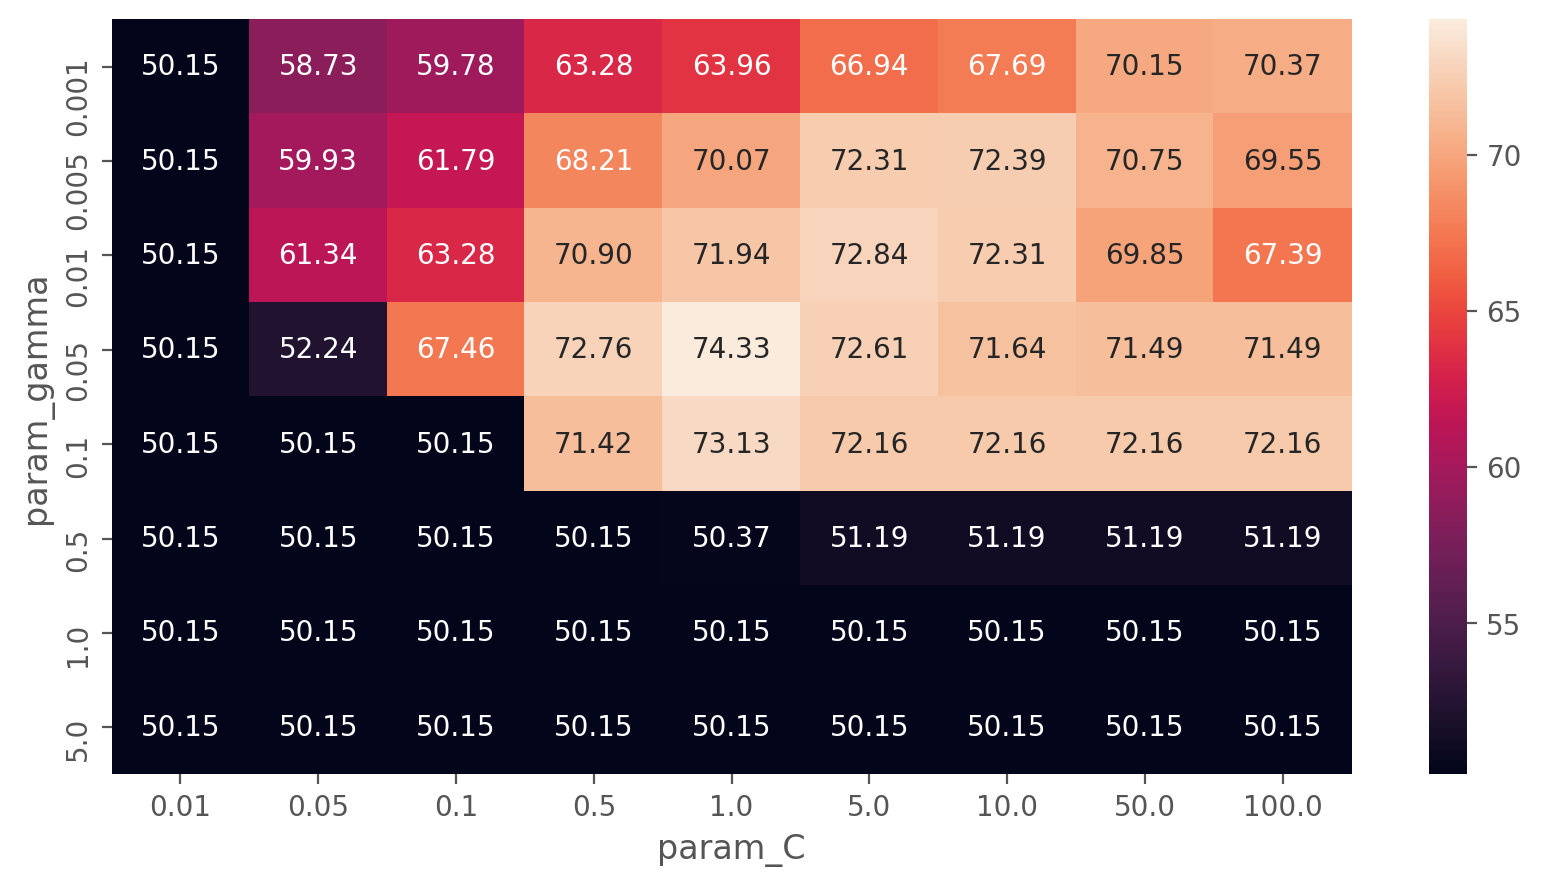

In [42]:
sns.heatmap(svm_lasso_results, annot=True, fmt='.2f')

In [46]:
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_art_train[:, art_lasso_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_lasso_selection])
(pred == y_art_test).mean()

0.7166666666666667

### Digits dataset

In [ ]:
%%capture
elasticnet.fit(X_dig_train, y_dig_train.flatten())

In [ ]:
elasticnet.l1_ratio_, elasticnet.alpha_

In [ ]:
lasso = Lasso(alpha=0.06)
lasso.fit(X_dig_train, y_dig_train)

In [ ]:
pred = np.ones(X_dig_test.shape[0])
pred[lasso.predict(X_dig_test) < 0] = -1

In [ ]:
(pred == y_dig_test).mean()

In [ ]:
dig_lasso_selection = lasso.coef_ != 0

In [ ]:
svm_lasso, svm_lasso_results = select_best_svm(
    X_dig_train[:, dig_lasso_selection],
    y_dig_train
)

In [ ]:
sns.heatmap(svm_lasso_results, annot=True, fmt='.2f')

In [98]:
svm = SVC(kernel='rbf', C=1, gamma=0.05)
svm.fit(X_dig_train[:, dig_lasso_selection], y_dig_train)
pred = svm.predict(X_dig_test[:, dig_lasso_selection])
(pred == y_dig_test).mean()

0.6954545454545454

<a id='Trees'></a>
# Trees

### Atrificial dataset

In [20]:
trees = ExtraTreesClassifier(n_estimators=500, criterion='gini', min_samples_split=10,
                    max_features=300)

In [21]:
trees.fit(X_art_train, y_art_train)

ExtraTreesClassifier(max_features=300, min_samples_split=10, n_estimators=500)

In [22]:
pred = trees.predict(X_art_test)

In [23]:
(pred == y_art_test).mean()

0.8393939393939394

In [24]:
px.histogram(trees.feature_importances_)

In [25]:
art_extra_tree_selection = trees.feature_importances_ > 0.005
art_extra_tree_selection.sum()

20

In [26]:
trees_better = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=3,
                    max_features=5)

trees_better.fit(X_art_train[:,art_extra_tree_selection], y_art_train)
pred = trees.predict(X_art_test)
(pred == y_art_test).mean()


0.8393939393939394

In [27]:
svm_extra_trees, svm_extra_trees_results = select_best_svm(
    X_art_train[:, art_extra_tree_selection],
    y_art_train
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

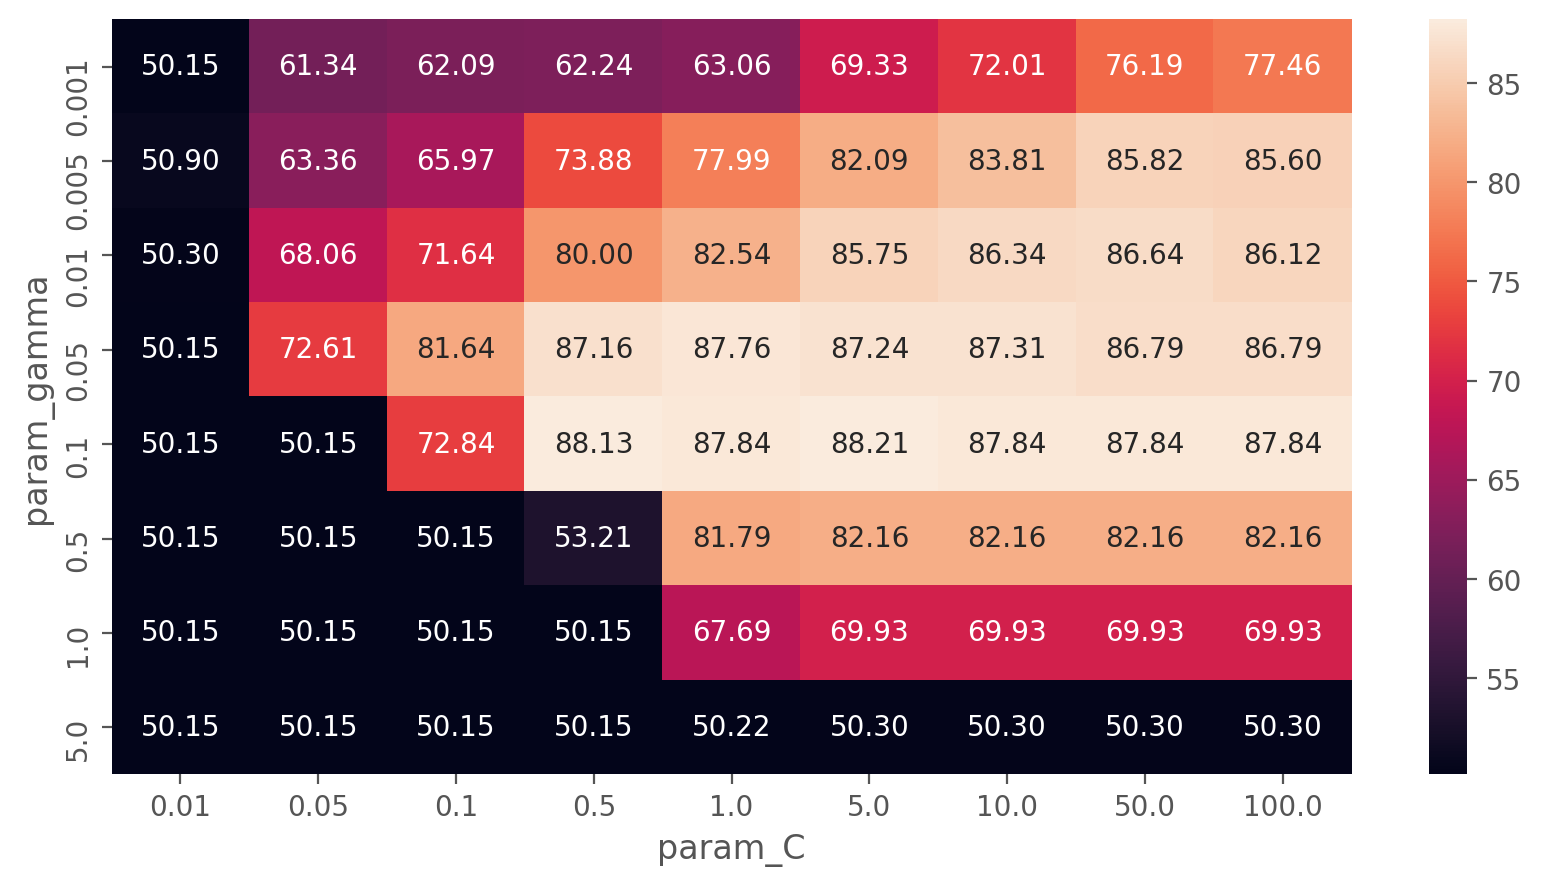

In [28]:
sns.heatmap(svm_extra_trees_results, annot=True, fmt='.2f')

In [72]:
svm = SVC(kernel='rbf', C=1.3, gamma=0.05, probability=True)
svm.fit(X_art_train[:, art_extra_tree_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_extra_tree_selection])
(pred == y_art_test).mean()

0.9090909090909091

### Digits dataset

In [74]:
trees.fit(X_dig_train, y_dig_train)

ExtraTreesClassifier(max_features=300, min_samples_split=10, n_estimators=500)

In [75]:
pred = trees.predict(X_dig_test)

In [76]:
(pred == y_dig_test).mean()

0.9772727272727273

In [77]:
px.histogram(trees.feature_importances_)

In [78]:
dig_extra_tree_selection = trees.feature_importances_ > 0.005
dig_extra_tree_selection.sum()

43

In [79]:
trees_better.fit(X_dig_train[:,dig_extra_tree_selection], y_dig_train)
pred = trees.predict(X_dig_test)
(pred == y_dig_test).mean()

0.9772727272727273

In [80]:
svm_extra_trees, svm_extra_trees_results = select_best_svm(
    X_dig_train[:, dig_extra_tree_selection],
    y_dig_train
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

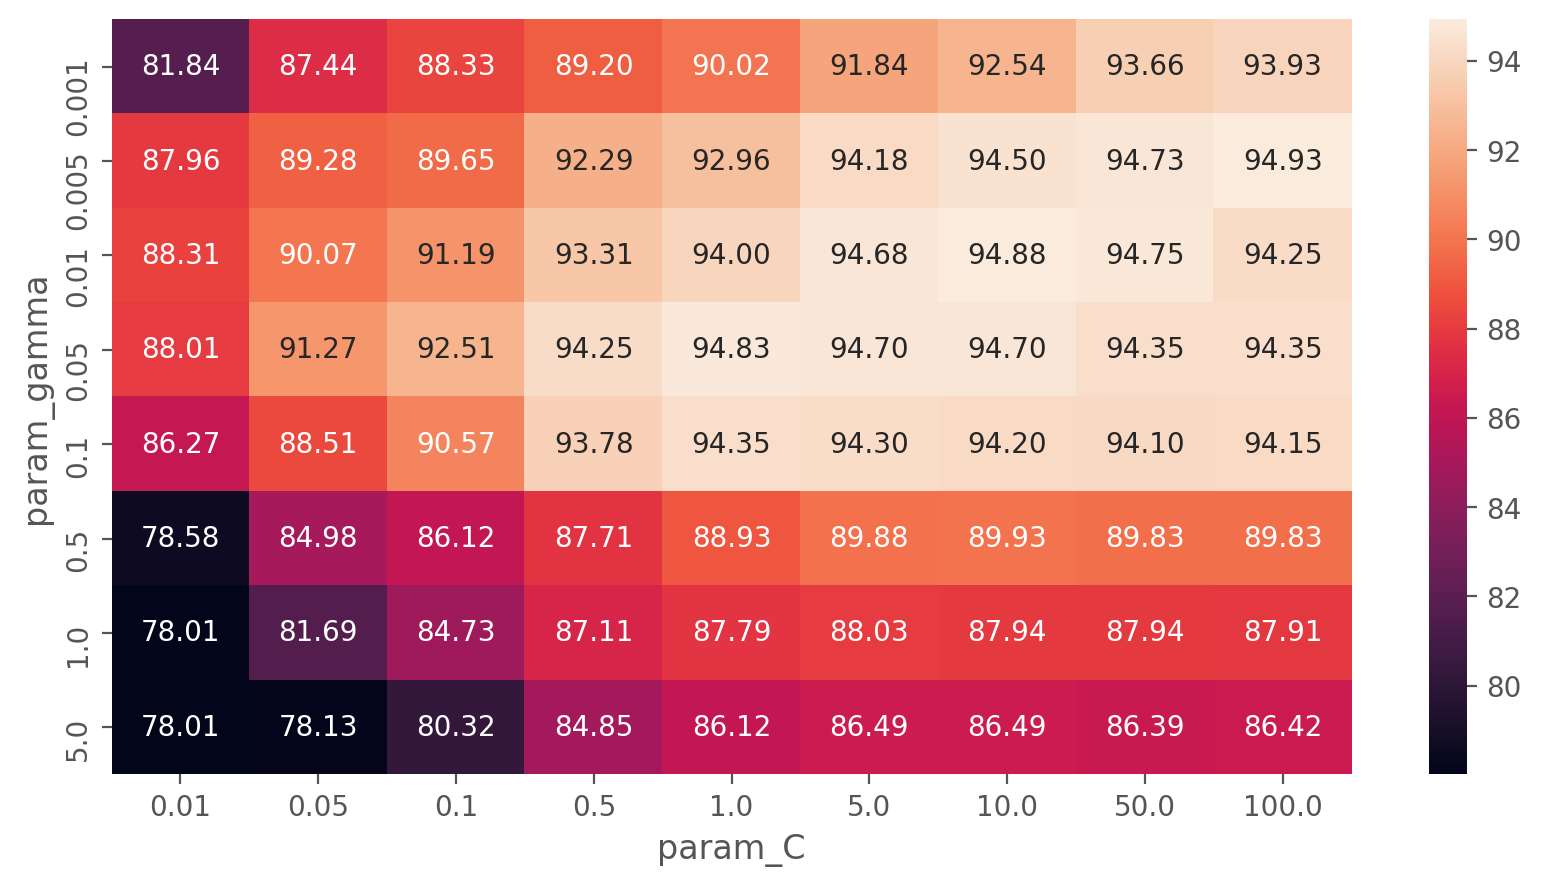

In [81]:
sns.heatmap(svm_extra_trees_results, annot=True, fmt='.2f')

In [86]:
svm = SVC(kernel='rbf', C=100, gamma=0.005, probability=True)
svm.fit(X_dig_train[:, dig_extra_tree_selection], y_dig_train)
pred = svm.predict(X_dig_test[:, dig_extra_tree_selection])
(pred == y_dig_test).mean()

0.9525252525252526

# Feature importance with SVM

### Atrificial dataset

Fitting 5 folds for each of 72 candidates, totalling 360 fits


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

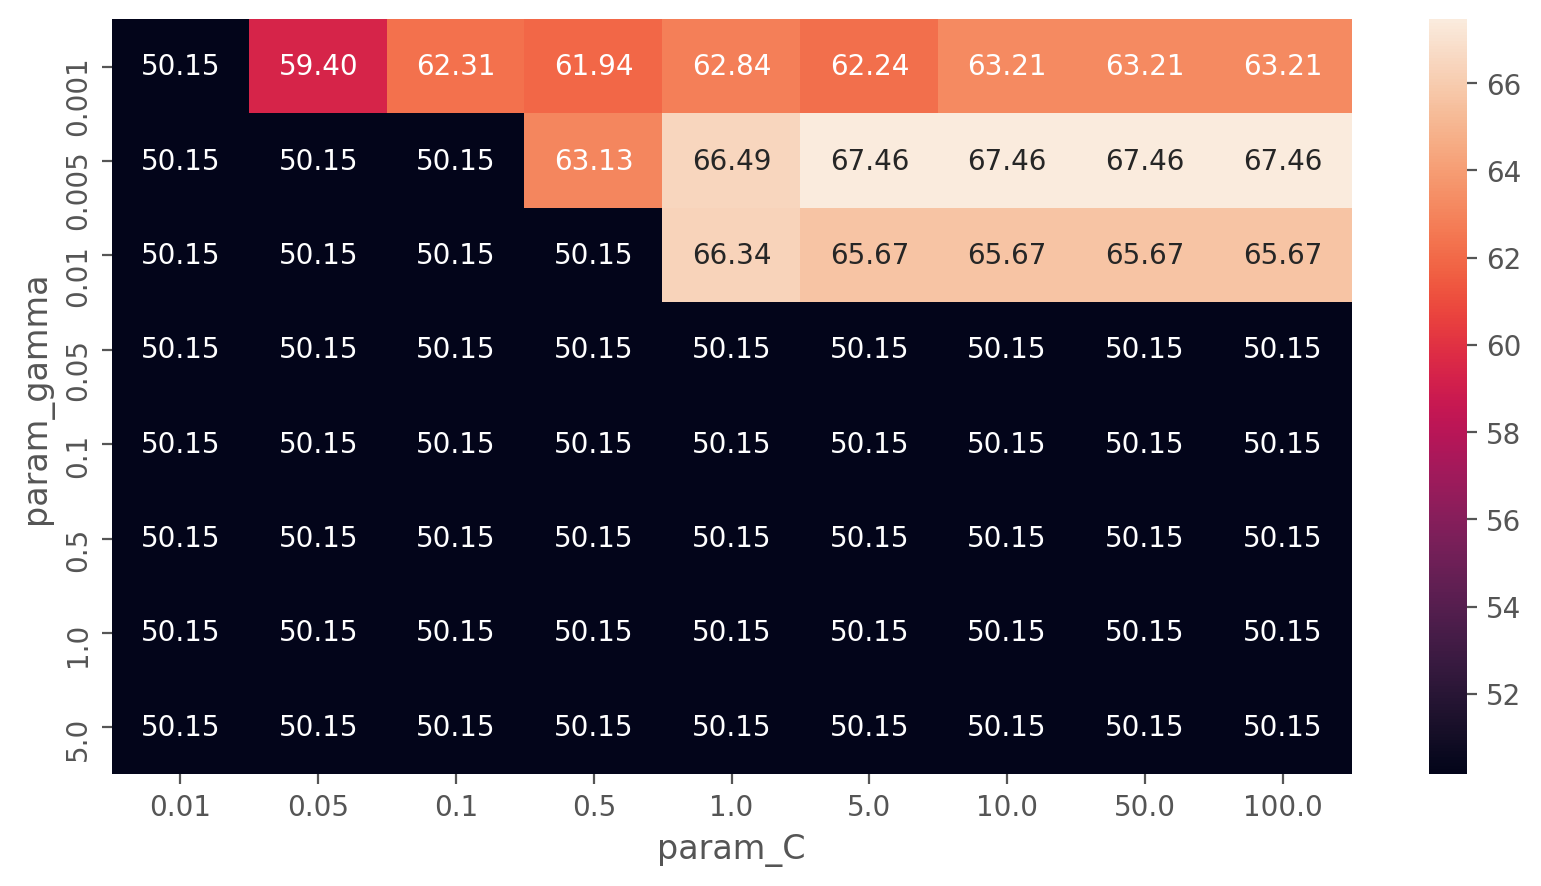

In [87]:
svm, svm_results = select_best_svm(X=X_art_train, y=y_art_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [94]:
svm = SVC(kernel='rbf', C=10, gamma=0.005)
svm.fit(X_art_train, y_art_train)
pred = svm.predict(X_art_test)
(pred == y_art_test).mean()

0.65

In [89]:
importance = permutation_importance(svm, X=X_art_train, y=y_art_train, n_repeats=4, n_jobs=-1)

In [90]:
px.histogram(importance['importances_mean'])

In [91]:
art_FI_selection = importance['importances_mean'] != 0
sum(art_FI_selection)

3

In [92]:
svm = SVC(C=100, kernel='rbf', gamma=0.01)
svm.fit(X_art_train[:, art_FI_selection], y_art_train)
pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, art_FI_selection]) < 0] = -1
(pred == y_art_test).mean()

0.6424242424242425

### Digits dataset

Fitting 5 folds for each of 20 candidates, totalling 100 fits


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

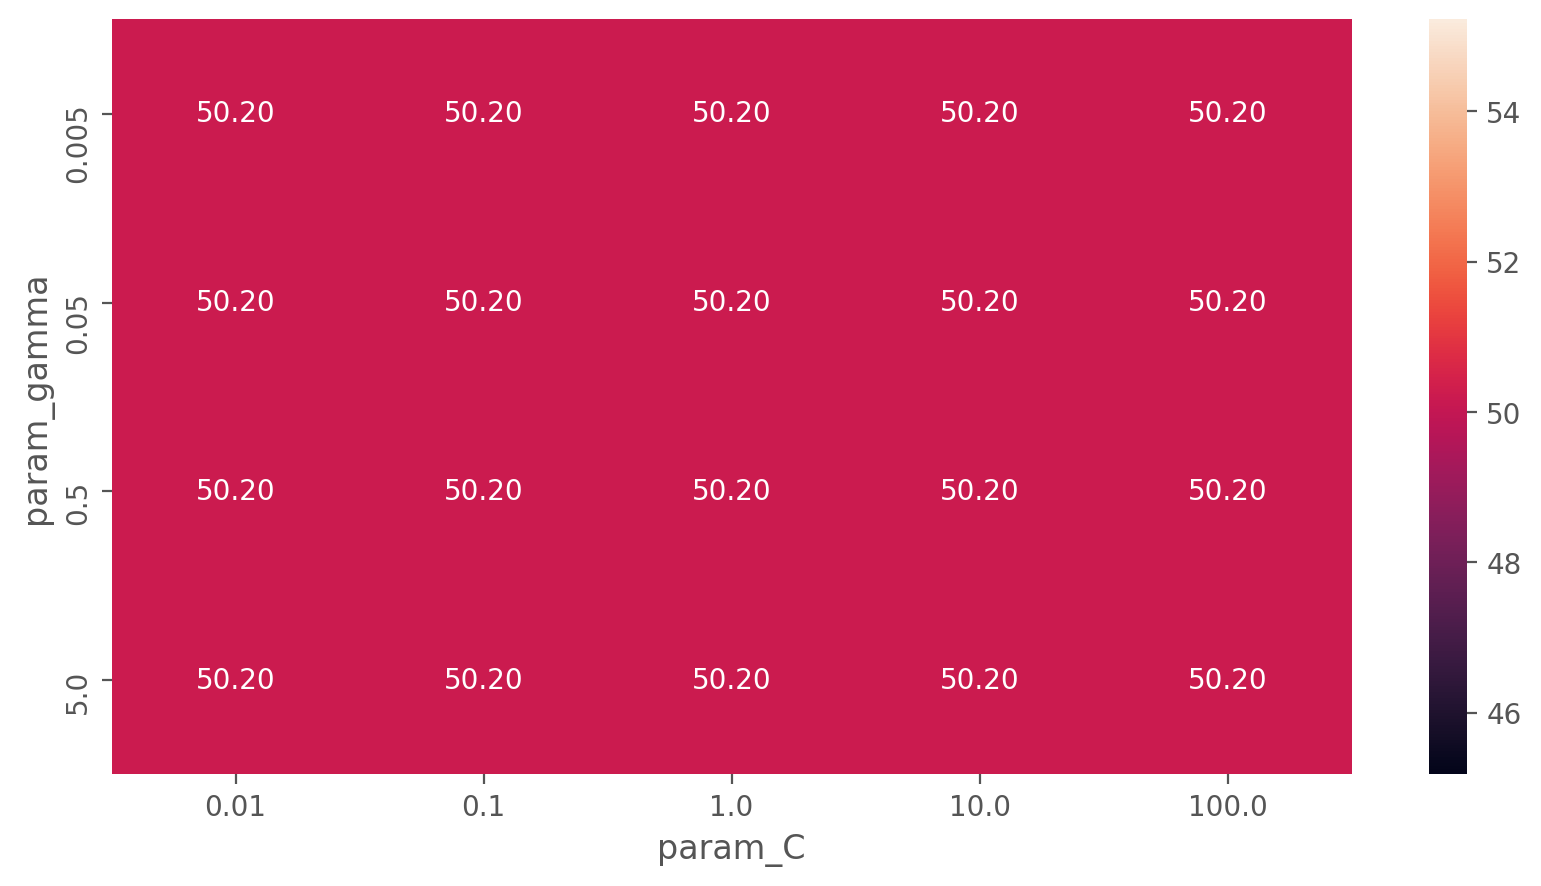

In [97]:
svm, svm_results = select_best_svm(X=X_dig_train, y=y_dig_train, reduced=True)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [107]:
svm = SVC(kernel='rbf', C=1, gamma=0.05)
svm.fit(X_dig_train, y_dig_train)
pred = svm.predict(X_dig_test)
(pred == y_dig_test).mean()

0.49595959595959593

<a id='RFE'></a>

# Recursive feature elimination

### Artificial dataset

In [108]:
from sklearn.feature_selection import RFE

In [109]:
gradboost = GradientBoostingClassifier(n_estimators=500, max_depth=10, max_features='auto')
gradboost.fit(X_art_train, y_art_train)
pred = gradboost.predict(X_art_test) 
(pred == y_art_test).mean()

0.7696969696969697

In [112]:
gradboost = GradientBoostingClassifier(n_estimators=50, max_depth=10, max_features='auto')
rfe = RFE(gradboost, n_features_to_select=20, step=50, verbose=1)
rfe.fit(X_art_train, y_art_train)

Fitting estimator with 500 features.
Fitting estimator with 450 features.
Fitting estimator with 400 features.
Fitting estimator with 350 features.
Fitting estimator with 300 features.
Fitting estimator with 250 features.
Fitting estimator with 200 features.
Fitting estimator with 150 features.
Fitting estimator with 100 features.
Fitting estimator with 50 features.


RFE(estimator=GradientBoostingClassifier(max_depth=10, max_features='auto',
                                         n_estimators=50),
    n_features_to_select=20, step=50, verbose=1)

In [113]:
art_rfe_selection = rfe.ranking_ == 1

In [114]:
pred = rfe.estimator_.predict(X_art_test[:, art_rfe_selection])
(pred == y_art_test).mean()

0.7909090909090909

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 353 out of 360 | elapsed:   19.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   20.0s finished


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

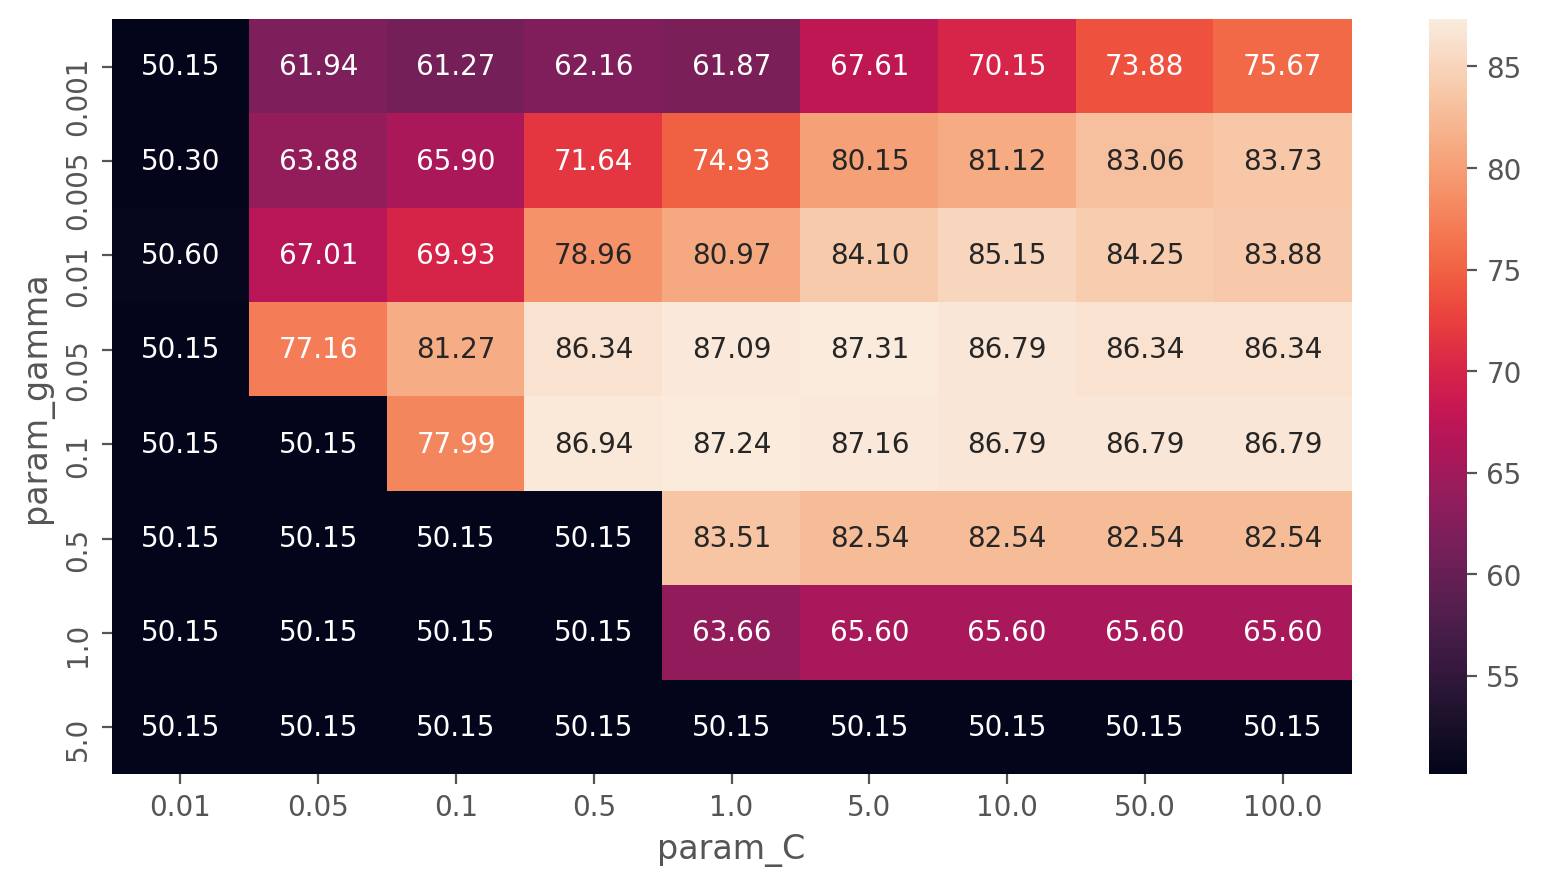

In [151]:
svm, svm_results = select_best_svm(X=X_art_train[:, art_rfe_selection], y=y_art_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [153]:
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_art_train[:, art_rfe_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_rfe_selection])
(pred == y_art_test).mean()

0.8939393939393939

### Digits dataset

In [ ]:
gradboost = GradientBoostingClassifier(n_estimators=500, max_depth=10, max_features='auto')
gradboost.fit(X_dig_train, y_dig_train)
pred = gradboost.predict(X_dig_test) 
(pred == y_dig_test).mean()

In [117]:
gradboost = GradientBoostingClassifier(n_estimators=50, max_depth=10, max_features='auto')
rfe = RFE(gradboost, n_features_to_select=20, step=1000, verbose=1)
rfe.fit(X_dig_train, y_dig_train)

Fitting estimator with 4955 features.
Fitting estimator with 3955 features.
Fitting estimator with 2955 features.
Fitting estimator with 1955 features.
Fitting estimator with 955 features.


RFE(estimator=GradientBoostingClassifier(max_depth=10, max_features='auto',
                                         n_estimators=50),
    n_features_to_select=20, step=1000, verbose=1)

In [118]:
dig_rfe_selection = rfe.ranking_ == 1

In [119]:
pred = rfe.estimator_.predict(X_dig_test[:, dig_rfe_selection])
(pred == y_dig_test).mean()

0.9424242424242424

Fitting 5 folds for each of 72 candidates, totalling 360 fits


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

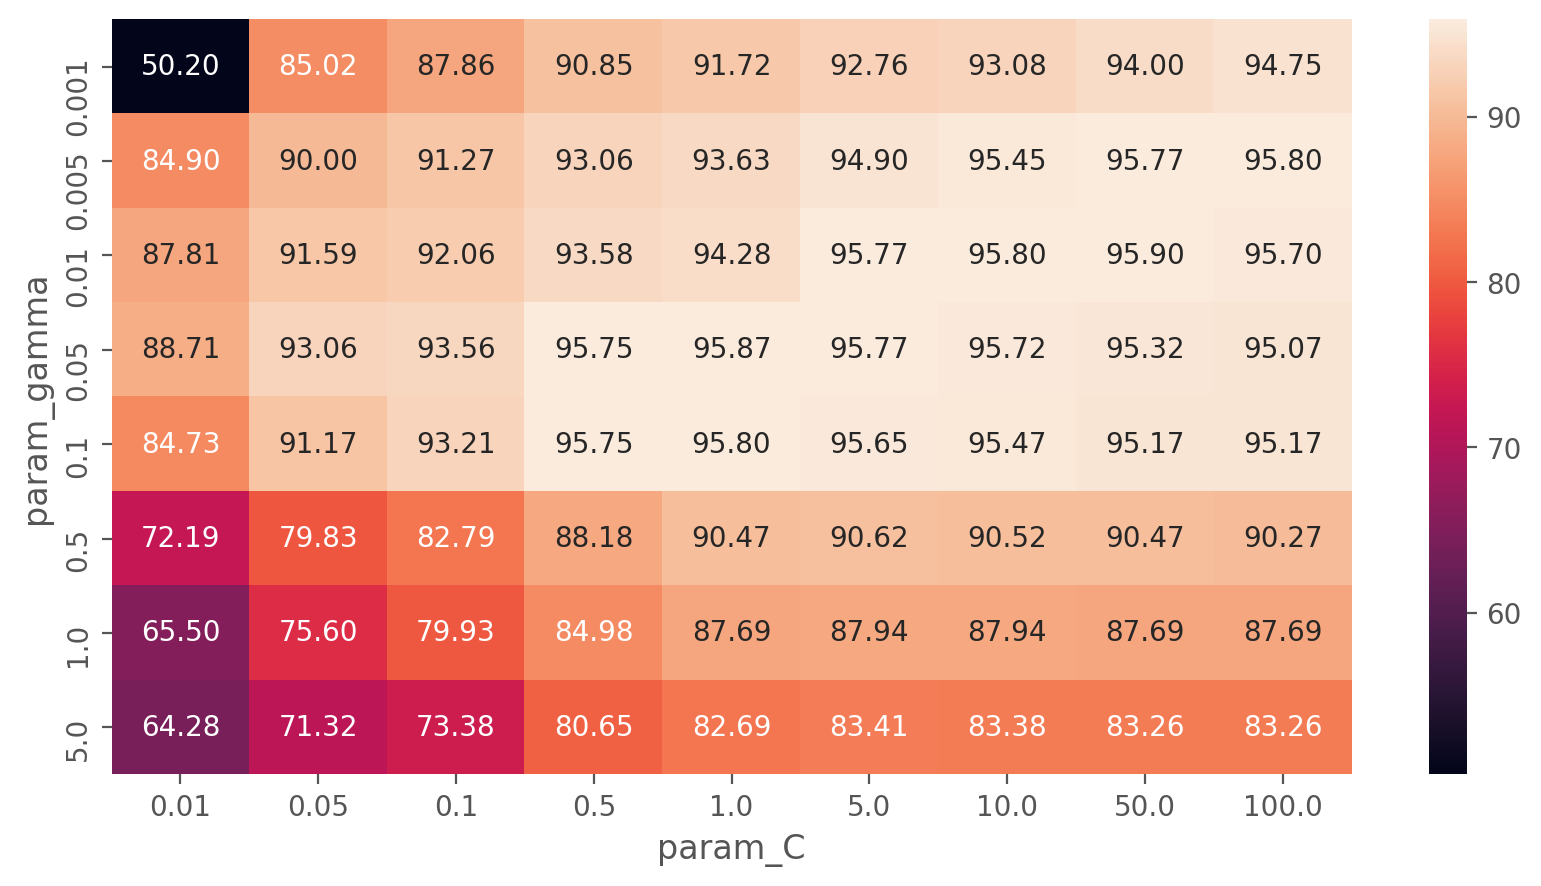

In [120]:
svm, svm_results = select_best_svm(X=X_dig_train[:, dig_rfe_selection], y=y_dig_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [121]:
svm = SVC(kernel='rbf', C=1, gamma=0.05)
svm.fit(X_dig_train[:, dig_rfe_selection], y_dig_train)
pred = svm.predict(X_dig_test[:, dig_rfe_selection])
(pred == y_dig_test).mean()

0.9575757575757575

In [122]:
(dig_rfe_selection == True).sum()

20

<a id='Boruta'></a>
# Boruta

### Artificial dataset

In [123]:
from boruta import BorutaPy
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [183]:
trees = ExtraTreesClassifier(n_estimators=100, criterion='gini', min_samples_split=10,
                    max_features='auto')
feat_selector = BorutaPy(trees, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X_art_train, y_art_train)
art_boruta_selection = feat_selector.support_
feat_selector.ranking_
# X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	479
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	16 / 100
Confirmed: 	16
Tenta

array([105, 316, 453, 435,  62,  53, 210, 341, 196,  87,  57,  72,  41,
       299, 165, 180,  24, 348,  19, 107, 348, 267, 432, 306, 177, 361,
        97, 385,   1, 280, 351, 468,  78, 220, 429,  75, 180, 440,  83,
       299, 416, 411, 336,  59, 228, 394,   1, 312,   1, 247, 169, 185,
       354,  14, 263, 110,  29, 387, 481, 293,  61, 476, 445, 268,   1,
       297, 343, 175, 220, 146, 400, 428, 397, 309,  65, 237, 225,  98,
        55, 116, 259, 118, 238, 241, 126, 201, 173, 327, 252, 452, 383,
       227, 365, 365, 245, 317, 426,  74, 388, 275, 210, 353,  60, 400,
       306,   1, 234, 467, 304, 148, 159, 173, 286, 402, 178, 236,  91,
        84, 460, 245, 165, 190, 337, 260,  76,  27, 201, 216,   1, 477,
        35, 163, 403, 301, 216, 310,   9,  99, 161, 208, 111, 308, 285,
       327, 248, 206, 112,  45,  68,  58, 266, 360, 231,   1, 233, 171,
        24, 220, 424, 379, 179,  30, 439, 161, 155,  53, 102,  93, 272,
       480, 385, 331, 127,  31, 183,  86, 151,   5, 408, 379,  6

In [179]:
trees = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', min_samples_split=2,
                    max_features='sqrt')
trees.fit(X_art_train[:, art_boruta_selection], y_art_train)
pred = trees.predict(X_art_test[:, art_boruta_selection])
(pred == y_art_test).mean()

0.9

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.2s finished


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

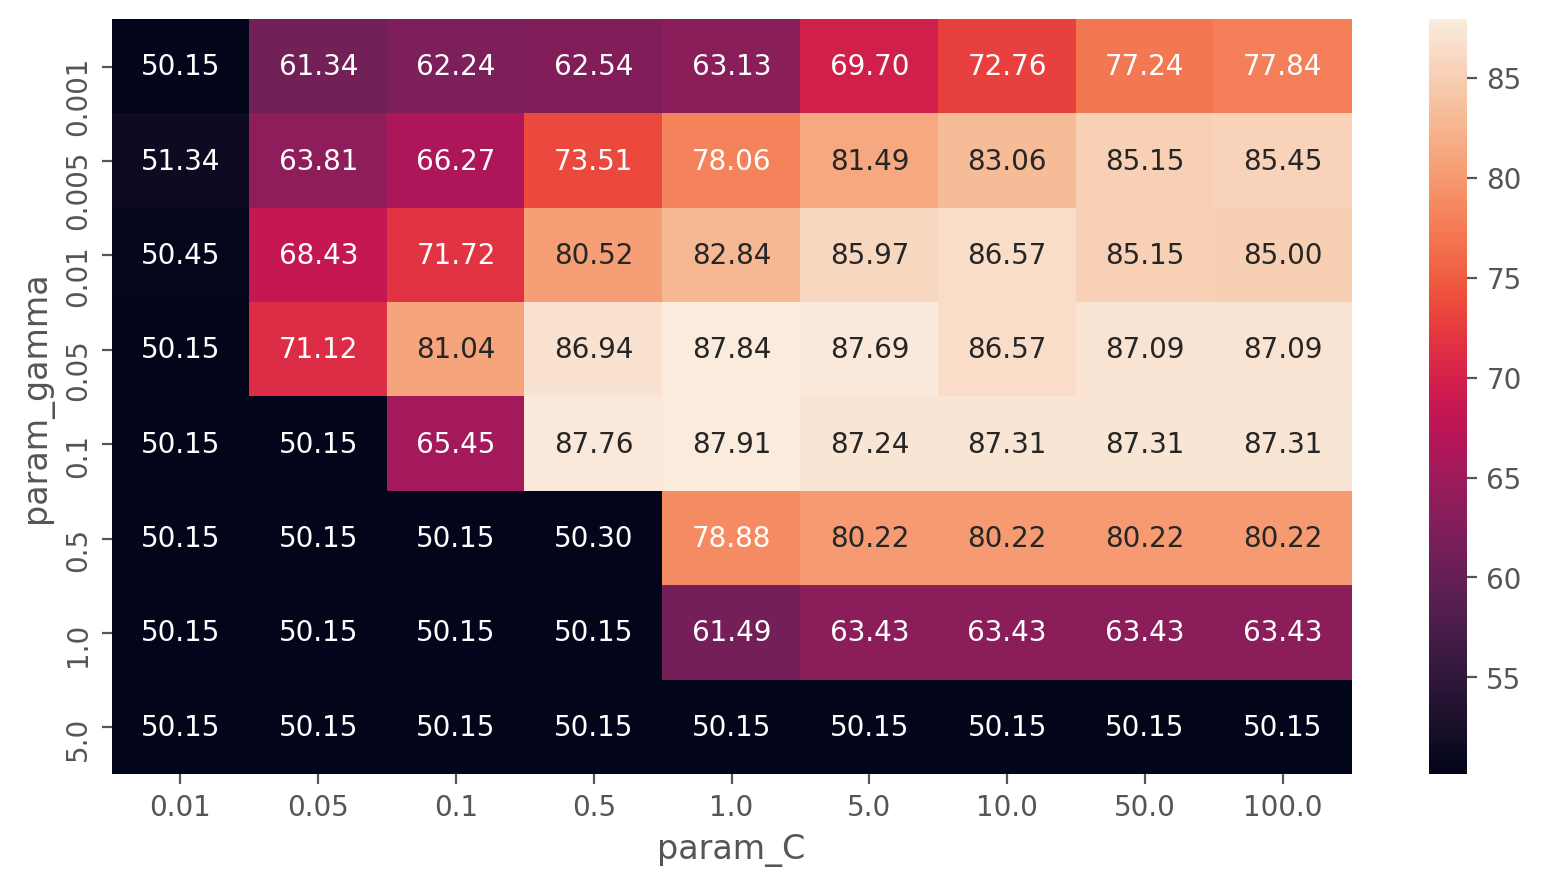

In [184]:
svm, svm_results = select_best_svm(X=X_art_train[:, art_boruta_selection], y=y_art_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [185]:
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_art_train[:, art_rfe_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_rfe_selection])
(pred == y_art_test).mean()

0.8939393939393939

### Digits dataset

In [130]:
feat_selector = BorutaPy(trees, n_estimators='auto', max_iter=10, verbose=2, random_state=1)
feat_selector.fit(X_dig_train, y_dig_train)
dig_boruta_selection = feat_selector.support_
feat_selector.ranking_

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	4955
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	4955
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	4955
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	4955
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	4955
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	4955
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	4955
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	1088
Tentative: 	325
Rejected: 	3542
Iteration: 	9 / 10
Confirmed: 	1088
Tentative: 	325
Rejected: 	3542


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	1088
Tentative: 	161
Rejected: 	3542


array([ 811, 2587,    1, ...,   98, 1042,    1])

In [131]:
trees = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', min_samples_split=2,
                    max_features='sqrt')
trees.fit(X_dig_train[:, dig_boruta_selection], y_dig_train)
pred = trees.predict(X_dig_test[:, dig_boruta_selection])
(pred == y_dig_test).mean()

0.9792929292929293

In [132]:
(dig_boruta_selection == True).sum()

1088

In [ ]:
svm, svm_results = select_best_svm(X=X_dig_train[:, dig_boruta_selection], y=y_dig_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [185]:
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_dig_train[:, dig_rfe_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_rfe_selection])
(pred == y_art_test).mean()

0.8939393939393939

<a id='XGBoost'></a>
# XGBoost

### Atrificial dataset

In [161]:
import xgboost as xgb
import shap
dtrain = xgb.DMatrix(X_art_train, label=y_art_train)
dtest = xgb.DMatrix(X_art_test, label=y_art_test)

In [188]:
num_round = 20
param = {'max_depth':20, 'eta': 0.1, 'alpha': 2, 'tree_method': 'hist'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param['nthread'] = 5
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-rmse:1.05411	train-rmse:1.02234
[1]	eval-rmse:1.00697	train-rmse:0.93469
[2]	eval-rmse:0.96490	train-rmse:0.85595
[3]	eval-rmse:0.92863	train-rmse:0.78420
[4]	eval-rmse:0.89897	train-rmse:0.72089
[5]	eval-rmse:0.87623	train-rmse:0.66285
[6]	eval-rmse:0.85621	train-rmse:0.61054
[7]	eval-rmse:0.83909	train-rmse:0.56445
[8]	eval-rmse:0.82739	train-rmse:0.52280
[9]	eval-rmse:0.81415	train-rmse:0.48495
[10]	eval-rmse:0.80246	train-rmse:0.45097
[11]	eval-rmse:0.79326	train-rmse:0.41987
[12]	eval-rmse:0.78937	train-rmse:0.39325
[13]	eval-rmse:0.78020	train-rmse:0.36806
[14]	eval-rmse:0.77931	train-rmse:0.34785
[15]	eval-rmse:0.77362	train-rmse:0.32827
[16]	eval-rmse:0.77167	train-rmse:0.31155
[17]	eval-rmse:0.76705	train-rmse:0.29397
[18]	eval-rmse:0.76603	train-rmse:0.27950
[19]	eval-rmse:0.76505	train-rmse:0.26677


In [189]:
pred = bst.predict(dtest, iteration_range=(0, bst.best_iteration))
pred[pred > 0] = 1
pred[pred < 0] = -1
(pred == y_art_test).mean()

0.806060606060606

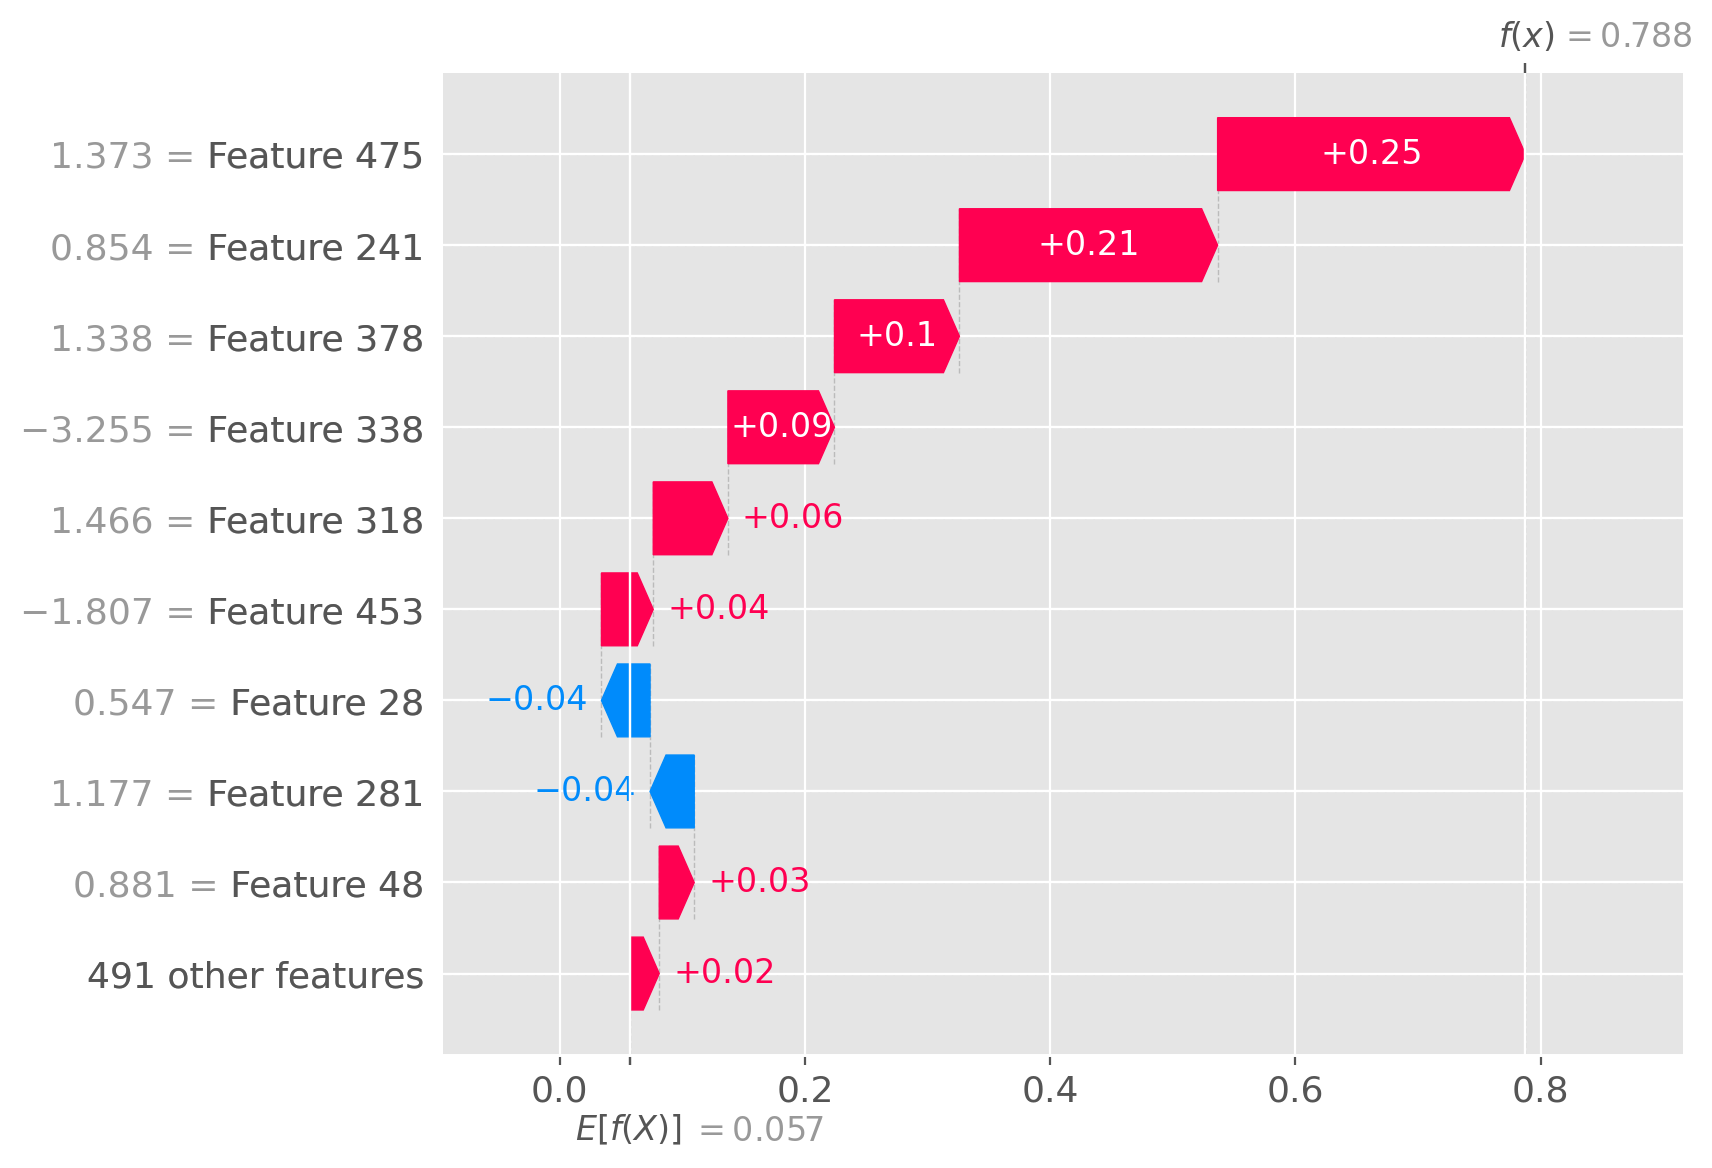

In [190]:
xgboost_explainer = shap.Explainer(bst)
xgboost_shap_values = xgboost_explainer(X_art_test)

# visualize the first prediction's explanation
shap.plots.waterfall(xgboost_shap_values[0])

As you see in the graph, feature 475 has the most impact on the model 

In [191]:
shap.initjs()
shap.plots.force(xgboost_shap_values[0])

here you can compare the SHAP value for feature 475 as compared to other features, to do so just change the index from 475 to any other feature index

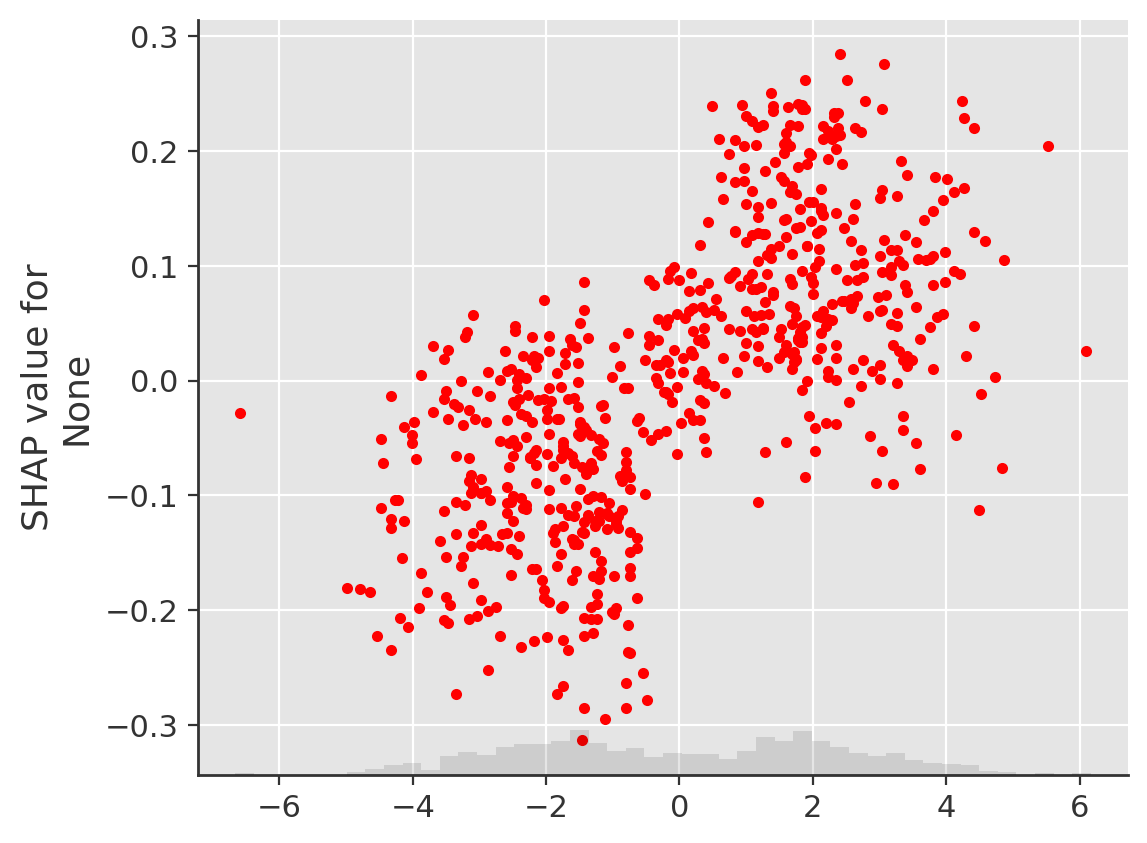

In [192]:
shap.initjs()
shap.plots.scatter(xgboost_shap_values[:,475], color='red')

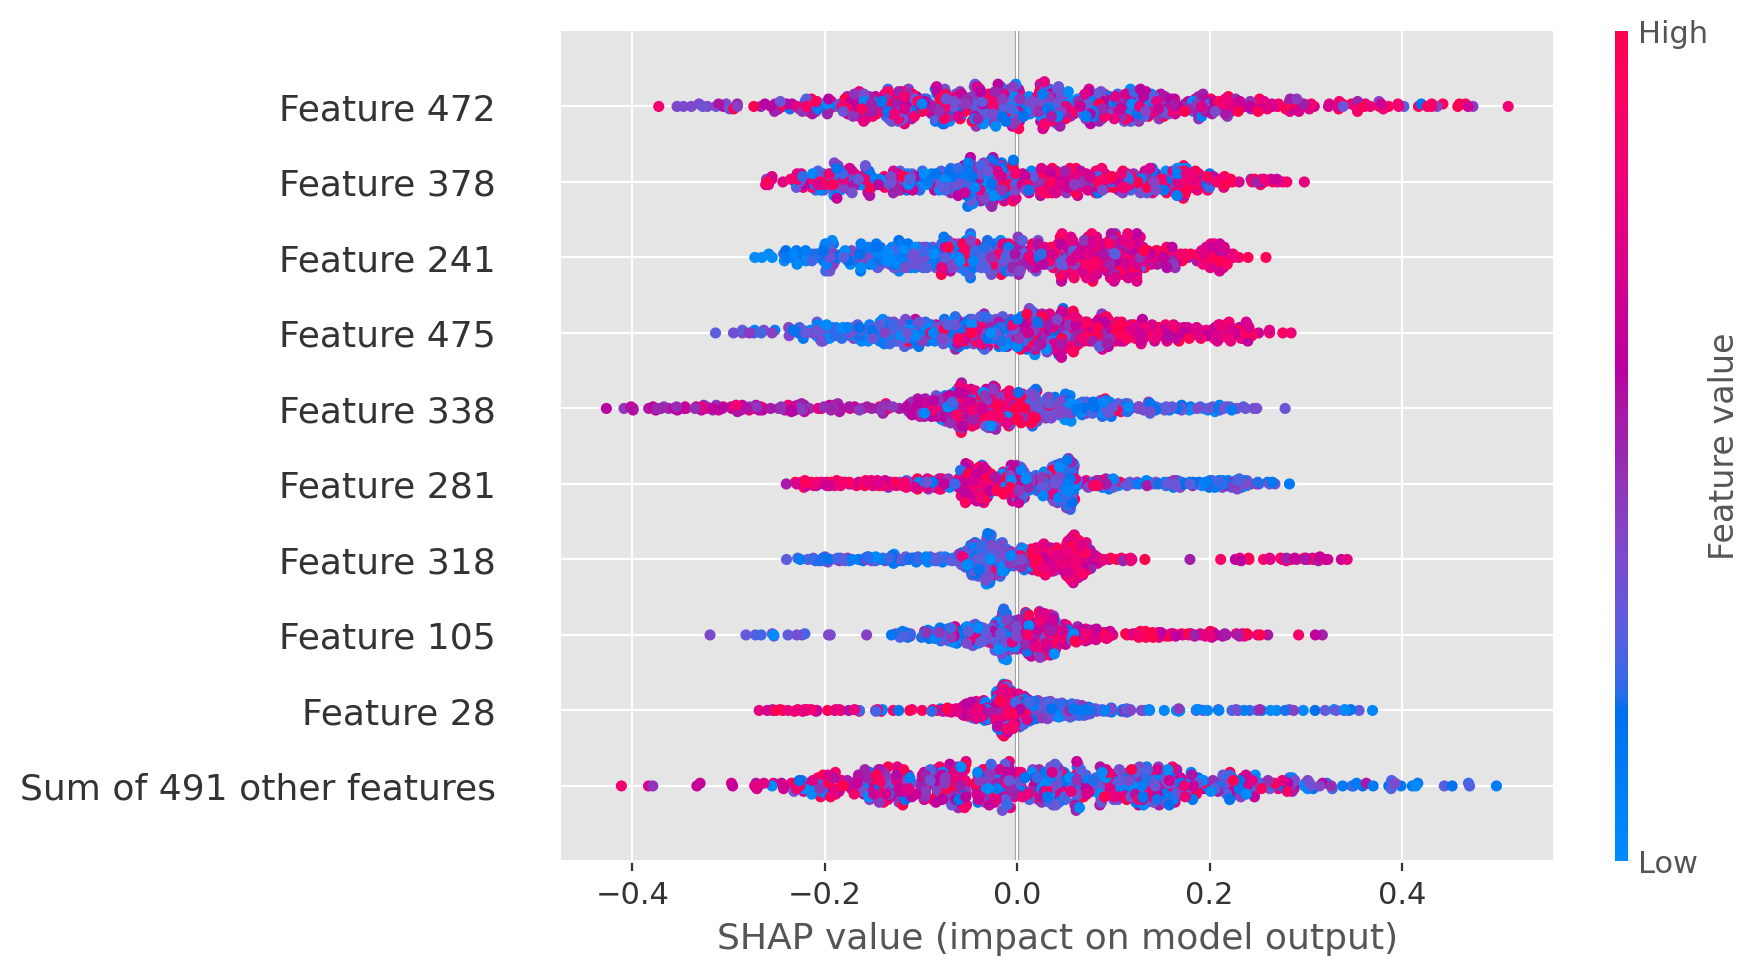

In [195]:
shap.plots.beeswarm(xgboost_shap_values)

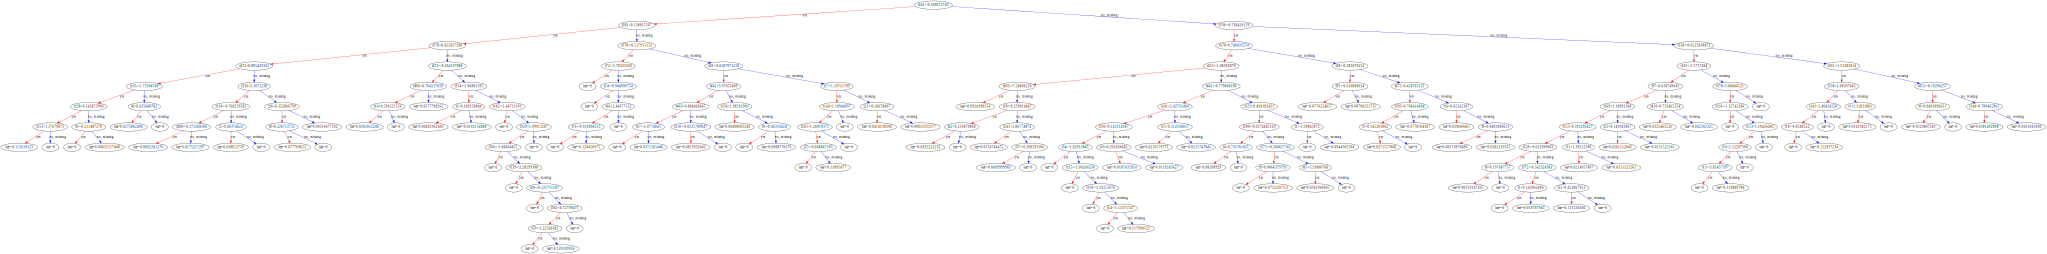

In [196]:
xgb.to_graphviz(bst, num_trees=2)

In [197]:
N = len(bst.get_fscore())
total = np.array(list(bst.get_fscore().values())).sum()
importances = bst.get_fscore()
importances.update((x, y/total) for x, y in importances.items())
importances_list = np.zeros(X_art.shape[1])
for feature, importance in importances.items():
    importances_list[int(feature.split('f')[1])] = importance

In [206]:
selected_importances = {feature:importance for feature, importance in importances.items() if importance > 0.005}
selected_importances

{'f475': 0.01066925315227934,
 'f153': 0.006789524733268671,
 'f378': 0.01988360814742968,
 'f442': 0.011154219204655674,
 'f105': 0.02230843840931135,
 'f17': 0.010184287099903006,
 'f8': 0.01066925315227934,
 'f28': 0.02279340446168768,
 'f229': 0.005819592628516004,
 'f5': 0.009699321047526674,
 'f48': 0.013094083414161009,
 'f453': 0.008244422890397672,
 'f1': 0.02279340446168768,
 'f98': 0.006789524733268671,
 'f478': 0.005819592628516004,
 'f102': 0.005819592628516004,
 'f338': 0.016488845780795344,
 'f318': 0.012609117361784675,
 'f3': 0.005819592628516004,
 'f472': 0.014064015518913677,
 'f241': 0.011154219204655674,
 'f4': 0.011639185257032008,
 'f0': 0.025703200775945685,
 'f10': 0.013094083414161009,
 'f12': 0.006304558680892337,
 'f22': 0.006304558680892337,
 'f6': 0.005819592628516004,
 'f13': 0.0072744907856450046,
 'f14': 0.007759456838021339,
 'f18': 0.005819592628516004,
 'f2': 0.011639185257032008,
 'f336': 0.00533462657613967,
 'f23': 0.00533462657613967,
 'f9': 0.00

In [207]:
important_features = importances_list > 0.005

In [208]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_art_train[:, important_features], y_art_train)

pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, important_features]) < 0] = -1
(pred == y_art_test).mean()

0.8803030303030303

### Digits dataset

In [136]:
dtrain = xgb.DMatrix(X_dig_train, label=y_dig_train)
dtest = xgb.DMatrix(X_dig_test, label=y_dig_test)

In [137]:
num_round = 4
param = {'max_depth':2, 'eta': 0.1}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param['nthread'] = 5
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-rmse:1.04461	train-rmse:1.04003
[1]	eval-rmse:0.97866	train-rmse:0.97340
[2]	eval-rmse:0.92039	train-rmse:0.91545
[3]	eval-rmse:0.86566	train-rmse:0.86110


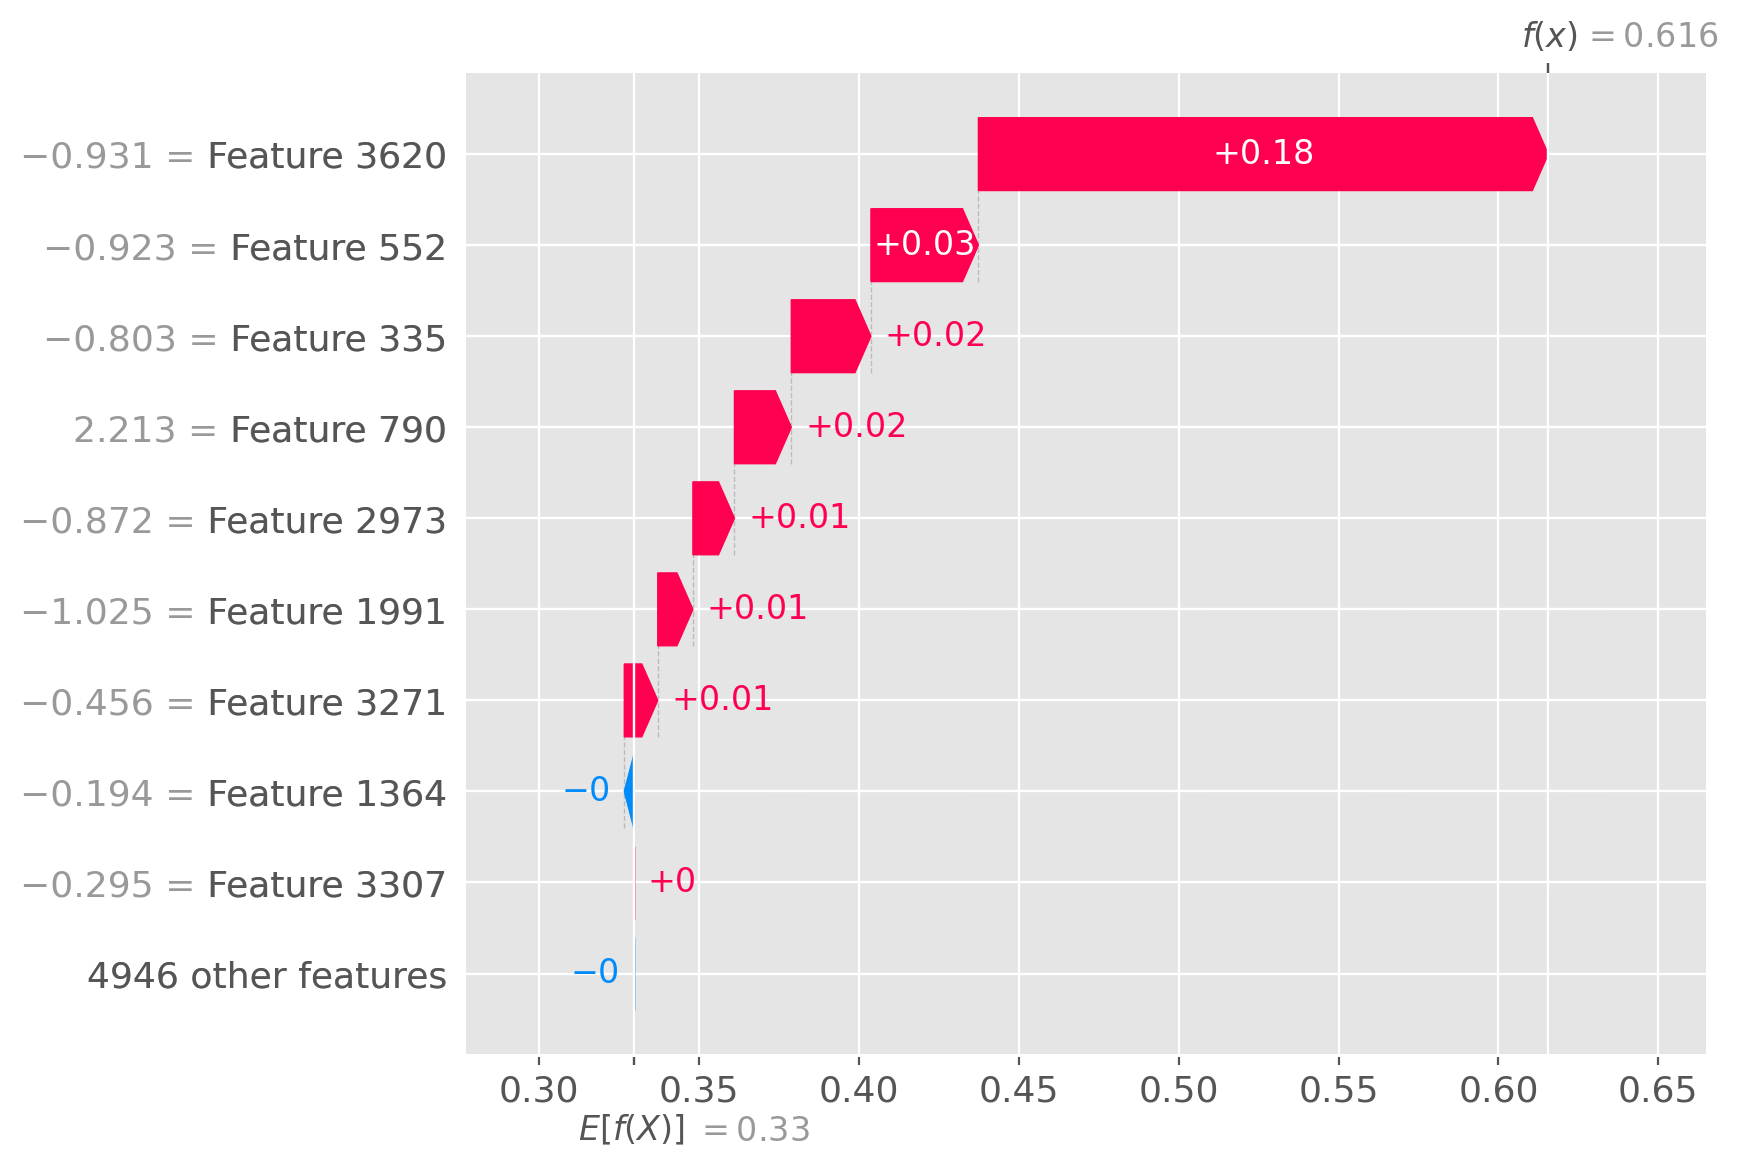

In [138]:
xgboost_explainer = shap.Explainer(bst)
xgboost_shap_values = xgboost_explainer(X_dig_test)

# visualize the first prediction's explanation
shap.plots.waterfall(xgboost_shap_values[0])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

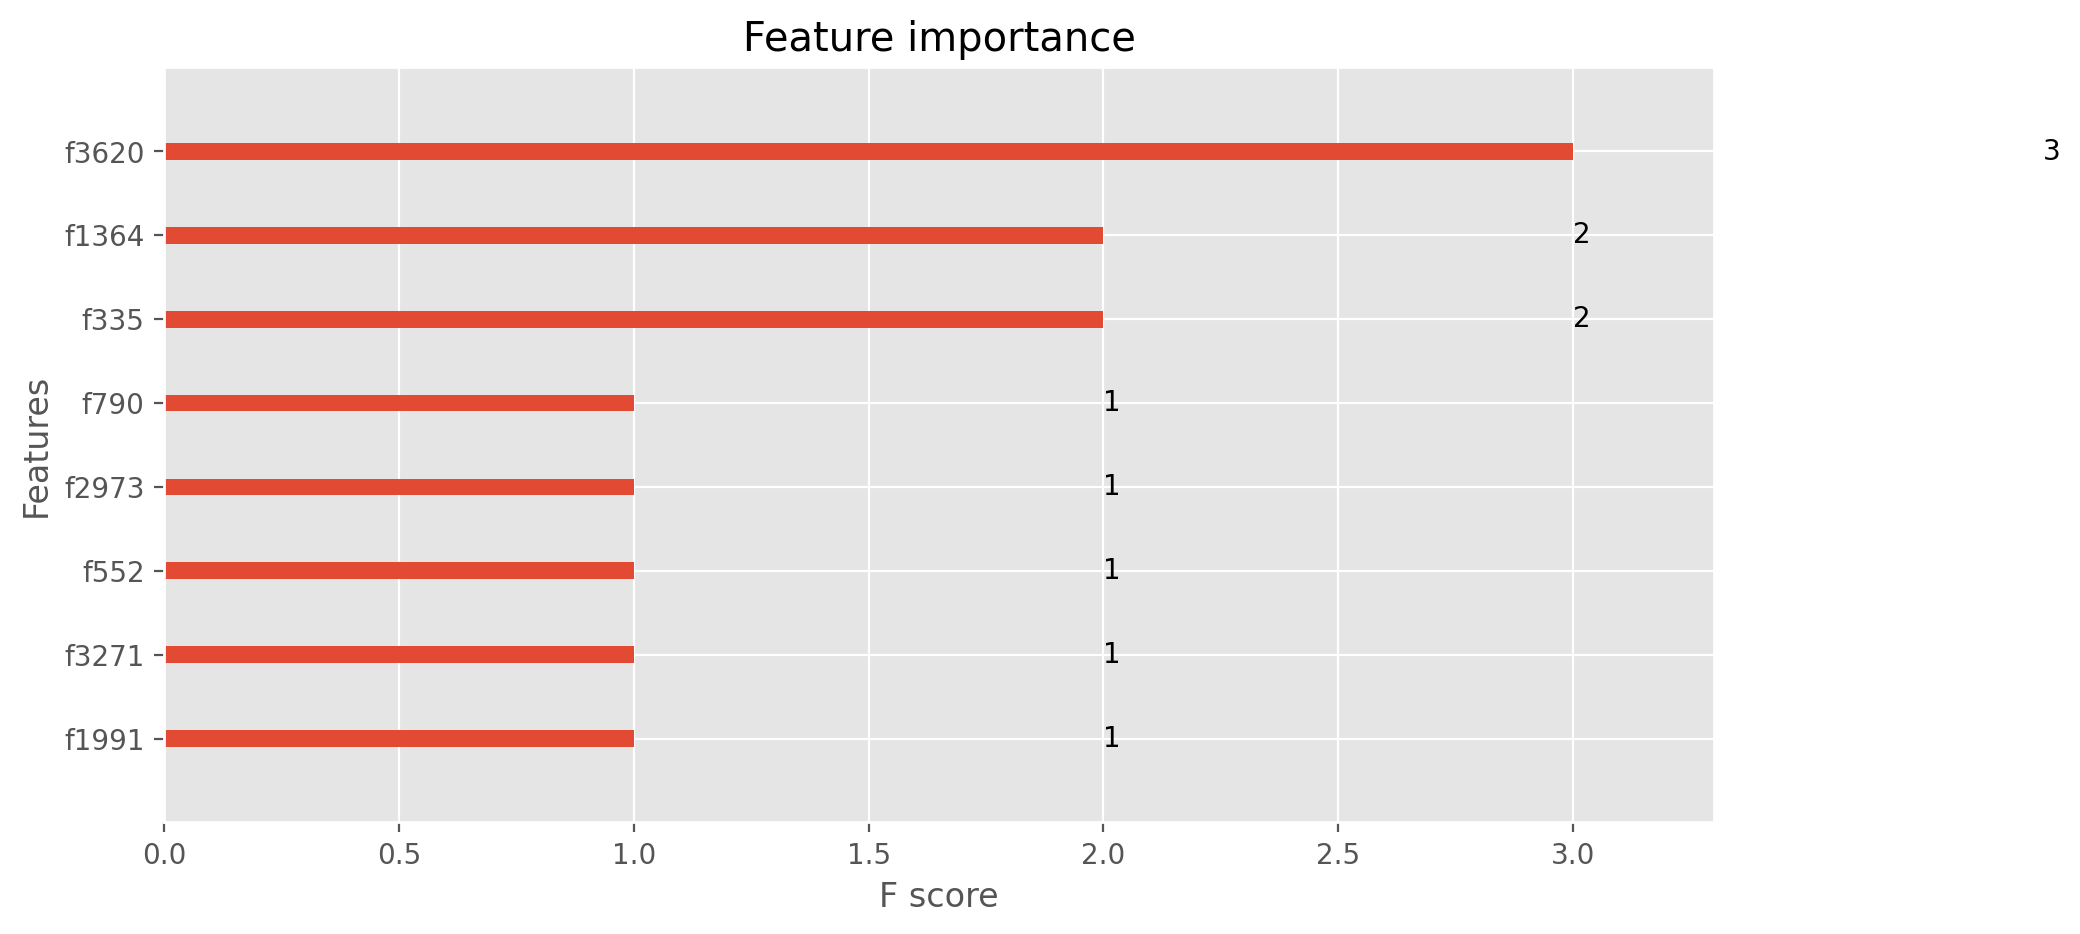

In [139]:
xgb.plot_importance(bst)

In [140]:
shap.initjs()
shap.plots.force(xgboost_shap_values[0])

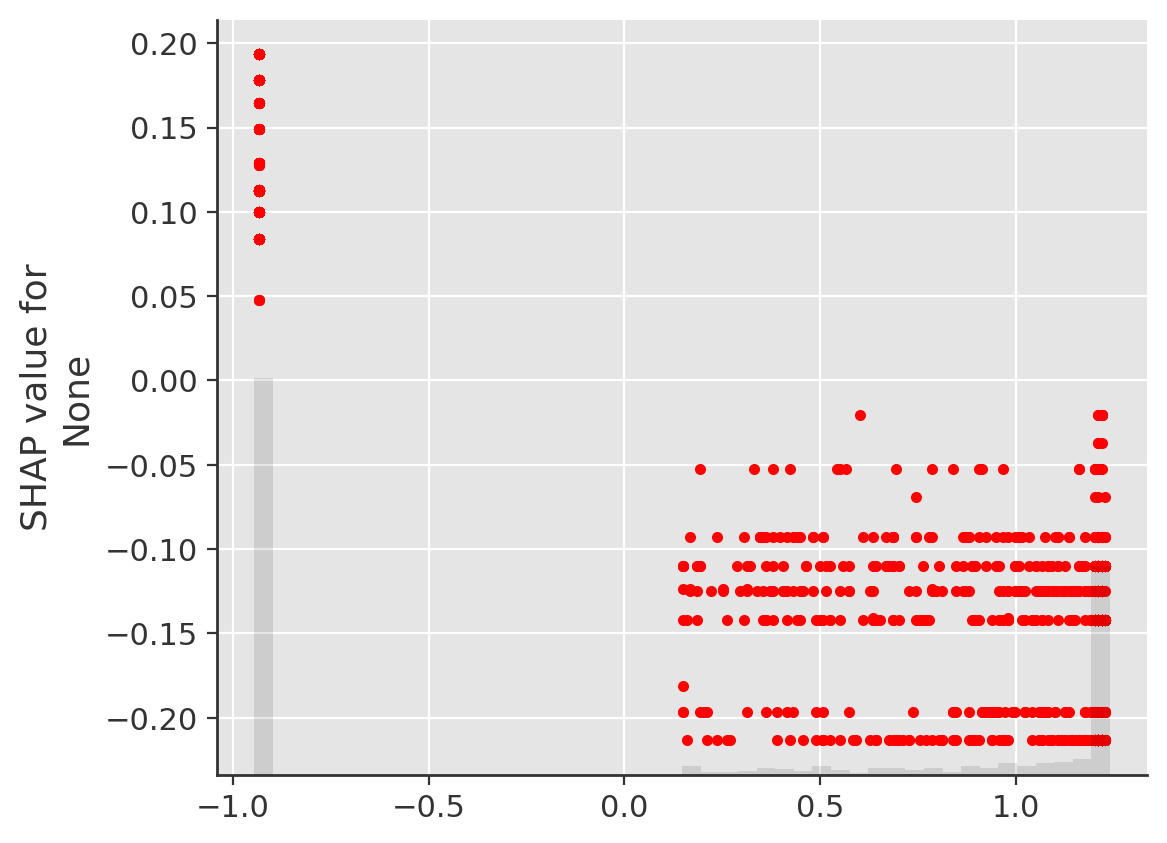

In [141]:
shap.initjs()
shap.plots.scatter(xgboost_shap_values[:,3620], color='red')

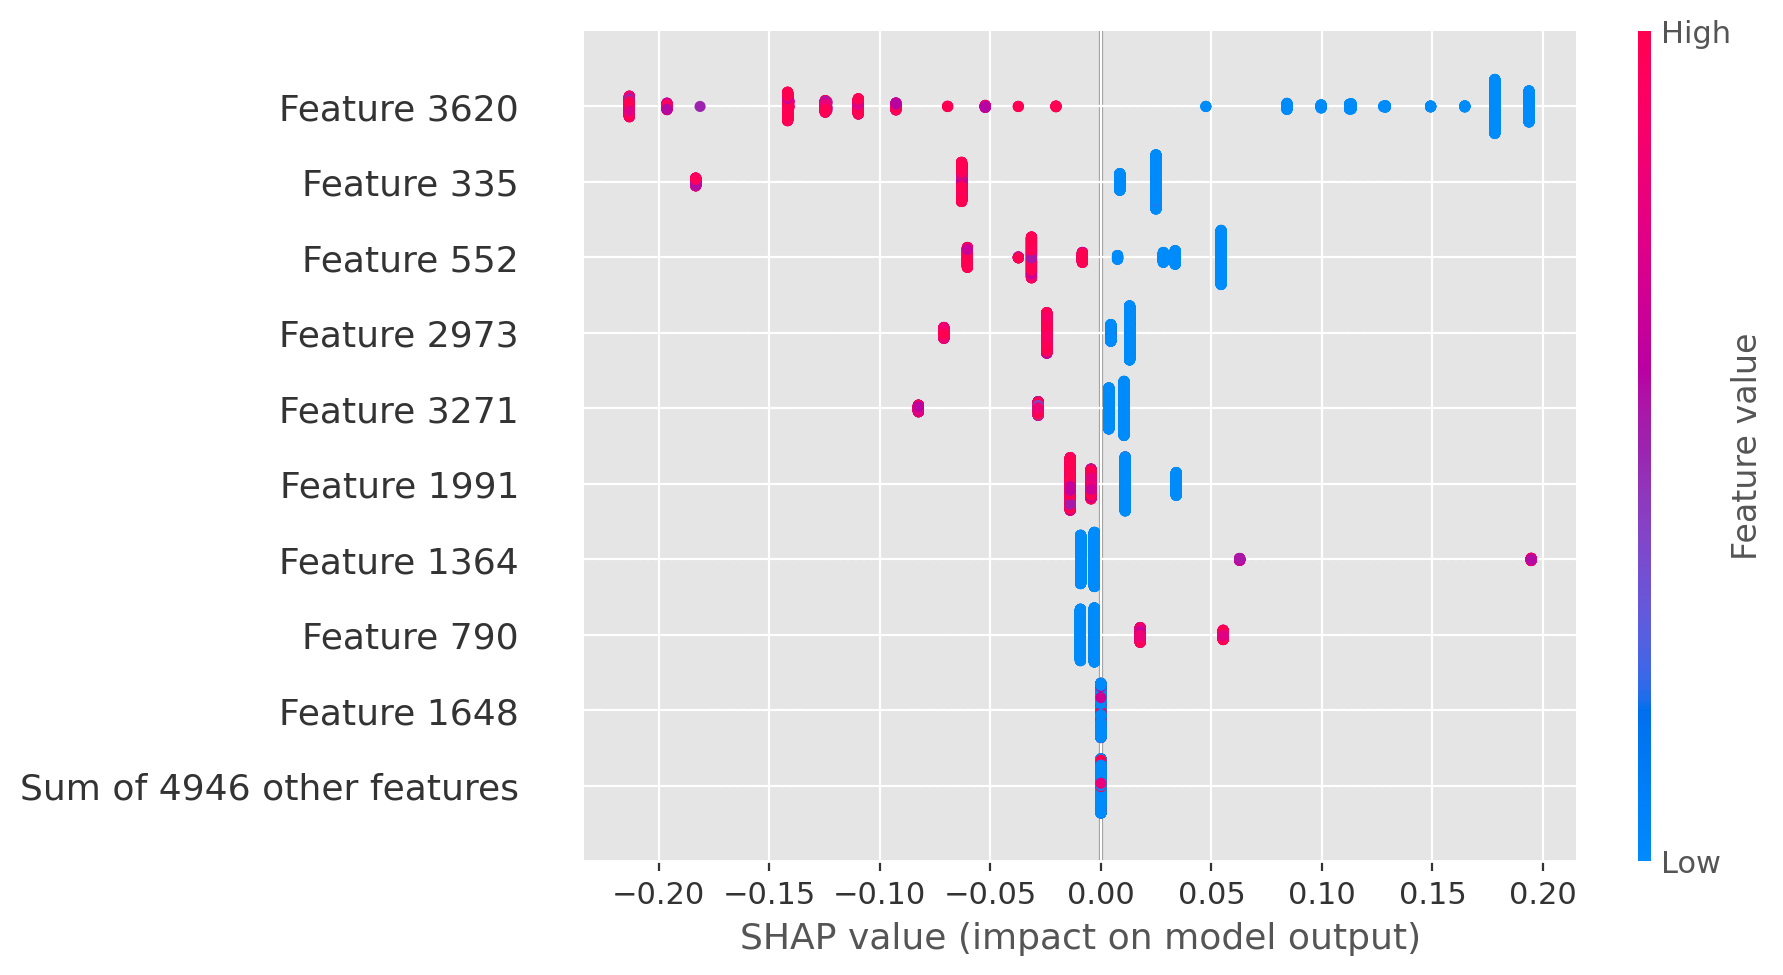

In [142]:
shap.plots.beeswarm(xgboost_shap_values)

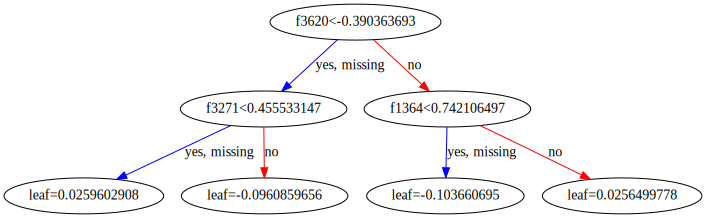

In [143]:
xgb.to_graphviz(bst, num_trees=2)

In [144]:
N = len(bst.get_fscore())
total = np.array(list(bst.get_fscore().values())).sum()
importances = bst.get_fscore()
importances.update((x, y/total) for x, y in importances.items())
importances_list = np.zeros(X_dig.shape[1])
for feature, importance in importances.items():
    importances_list[int(feature.split('f')[1])] = importance

In [145]:
selected_importances = {feature:importance for feature, importance in importances.items() if importance > 0.05}
selected_importances

{'f3620': 0.25,
 'f335': 0.16666666666666666,
 'f1364': 0.16666666666666666,
 'f1991': 0.08333333333333333,
 'f3271': 0.08333333333333333,
 'f552': 0.08333333333333333,
 'f2973': 0.08333333333333333,
 'f790': 0.08333333333333333}

In [146]:
important_features = importances_list > 0.05

In [147]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_dig_train[:, important_features], y_dig_train)

pred = np.ones(X_dig_test.shape[0])
pred[svm.predict(X_dig_test[:, important_features]) < 0] = -1
(pred == y_dig_test).mean()

0.9212121212121213

In [148]:
len(selected_importances)

8

# Final prediction

## Artifitial dataset

In [297]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art_train[:, art_extra_tree_selection], y_art_train)

pred = svm.predict(X_art_test[:, art_extra_tree_selection])
(pred == y_art_test).mean()

SVC(C=1, gamma=0.1, probability=True)

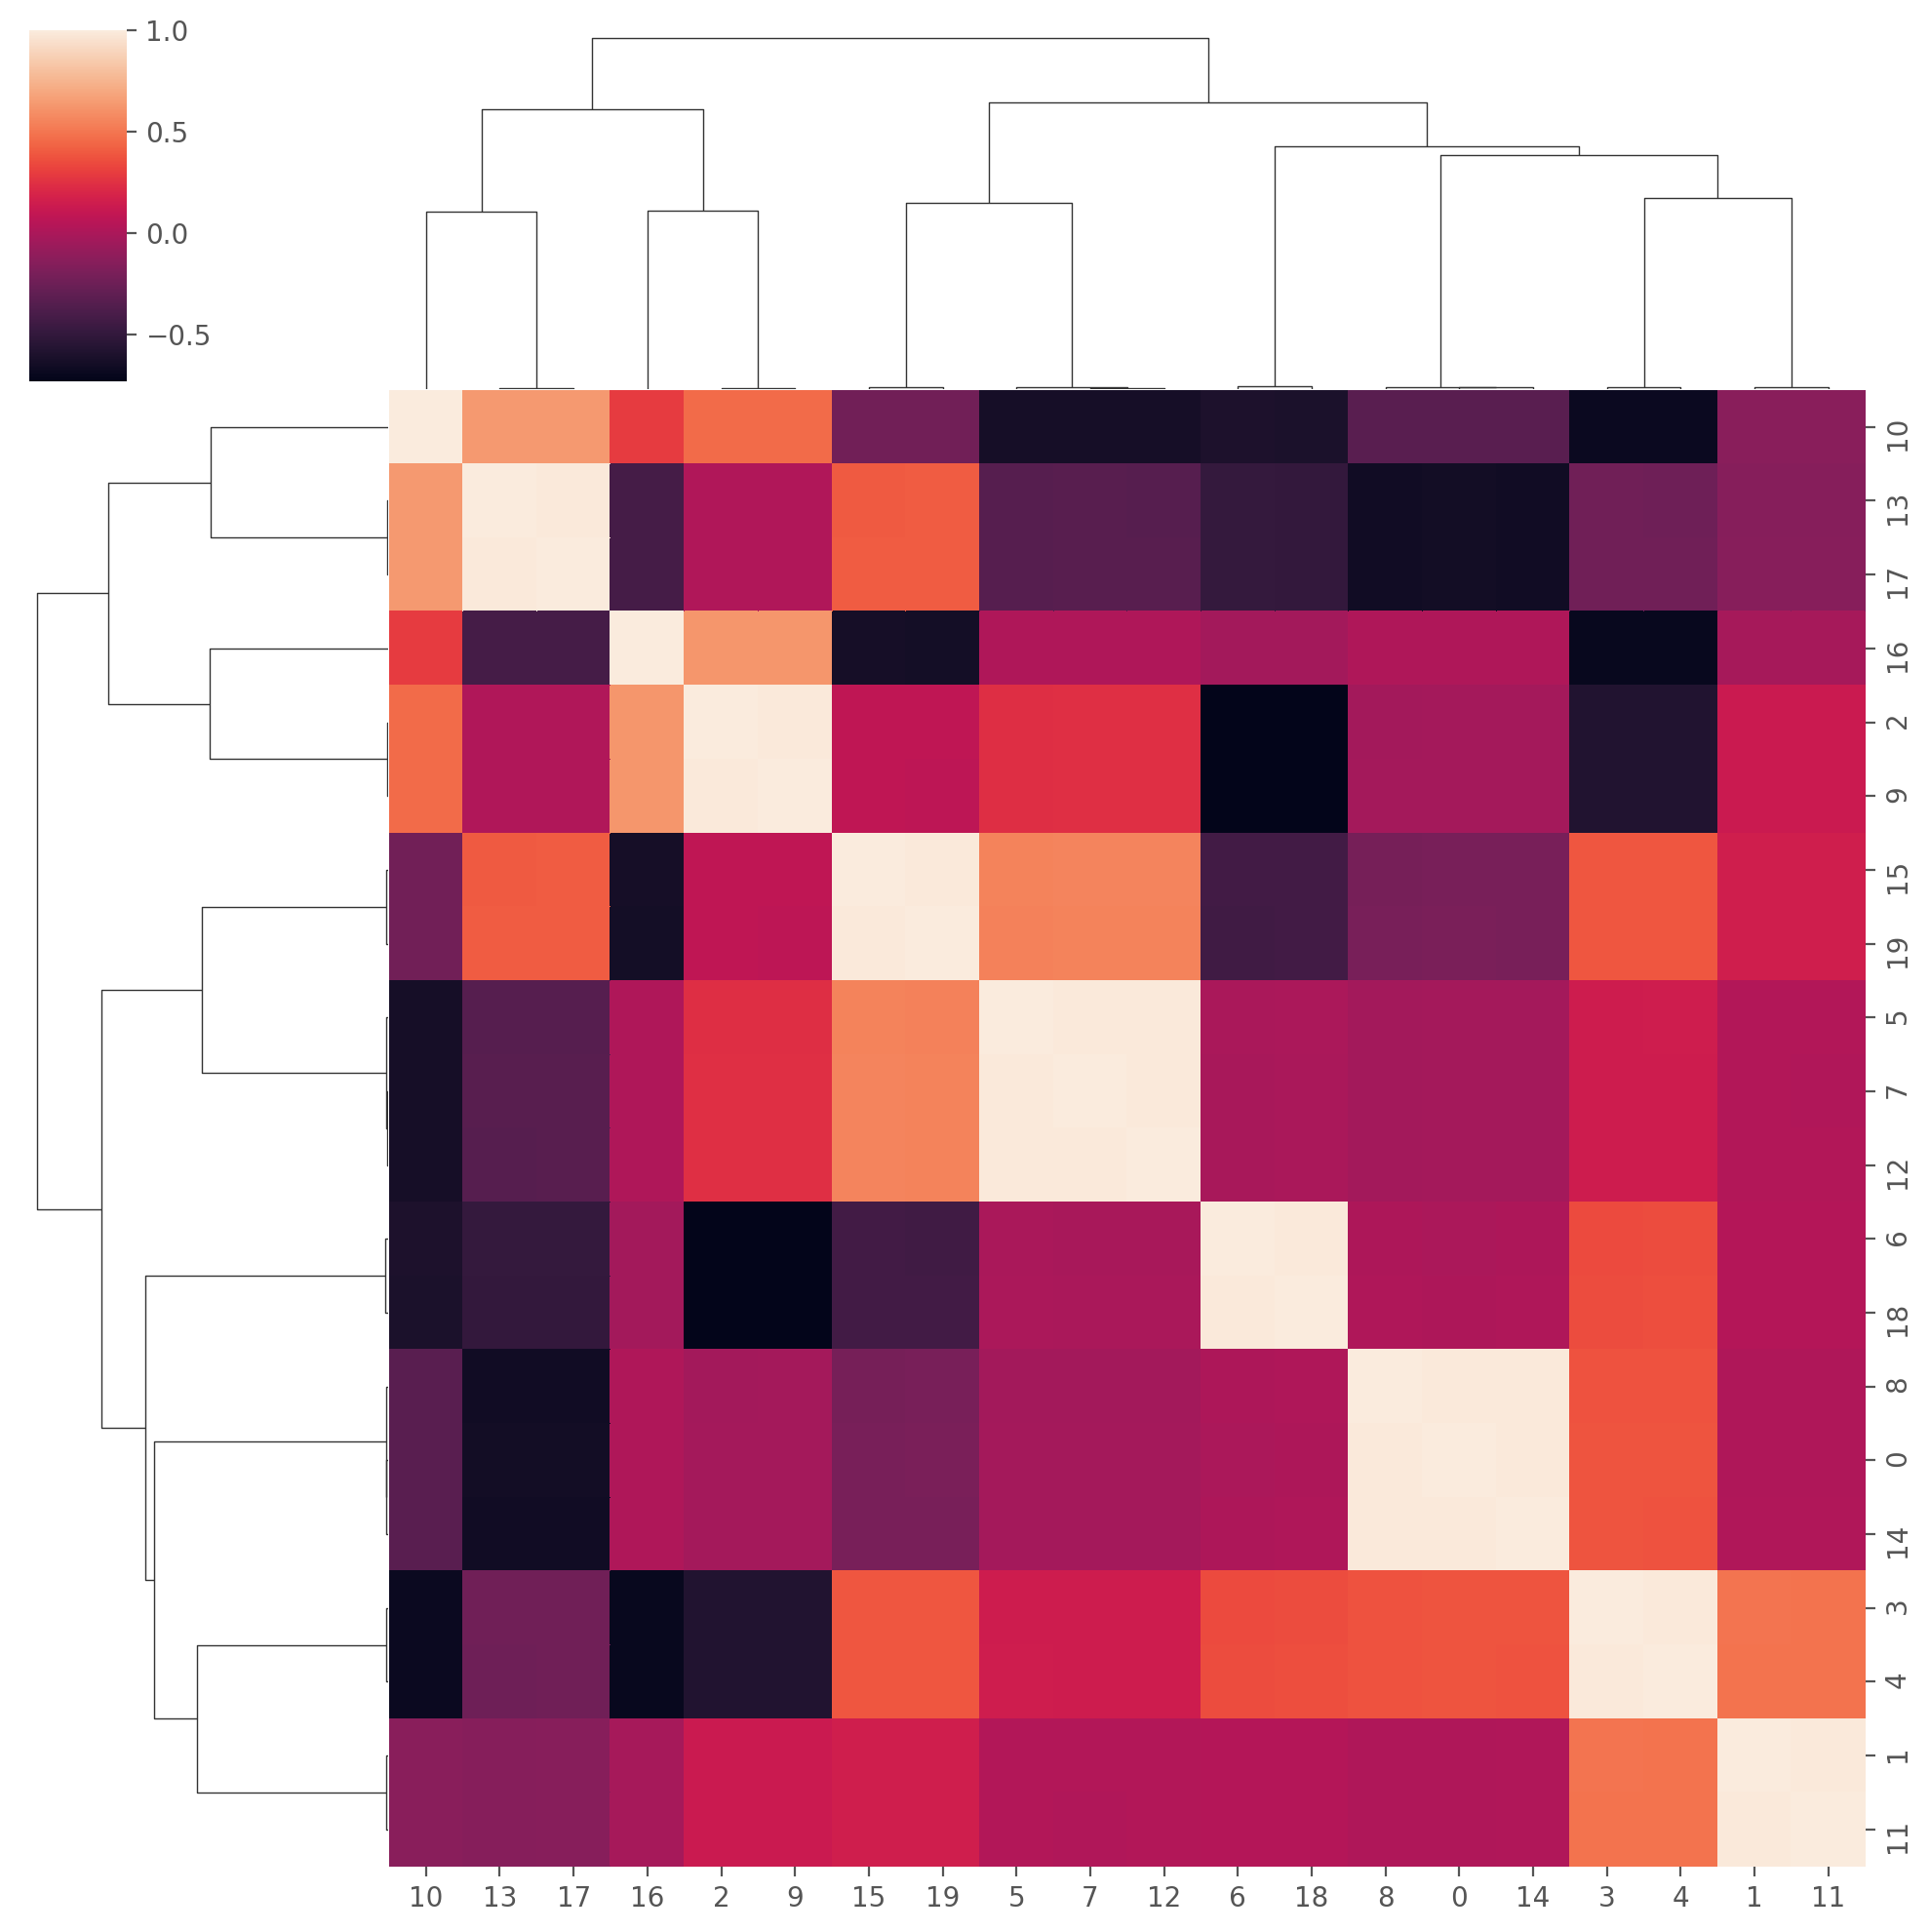

In [299]:
sns.clustermap(np.corrcoef(X_art_train[:, art_extra_tree_selection].T))

It is clear that almost all predictors have some copy so removal of copied predictors should not worse our predictor.

In [331]:
final_features = [10, 13, 16, 2, 15, 5, 6, 8, 3, 1]
redundant_features = [17, 9, 19, 7, 12, 18, 0, 14, 4, 11]

In [333]:
final_art_selection = np.where(art_extra_tree_selection)[0][final_features]

In [336]:
X_art_train[:, final_art_selection].shape

(1340, 10)

In [351]:
final_art_selection

array([338, 442, 455,  64, 453, 153, 241, 318, 105,  48])

In [348]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art_train[:, final_art_selection], y_art_train)
pred = svm.predict(X_art_test[:, final_art_selection])
(pred == y_art_test).mean()

0.8893939393939394

In [349]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art[:, final_art_selection], y_art)

SVC(C=1, gamma=0.1, probability=True)

In [353]:
val_pred = svm.predict_proba(val_art[:, final_art_selection])
save_to_file(dataset='artificial', predictions=val_pred[:, 1], feature_indices=final_art_selection)

In [355]:
px.histogram(val_pred[:, 0])